**Contexto:**

Somos un banco que dispone de una base de datos con una gran cantidad de información sobre nuestros clientes. Nuestro objetivo es ayudar a los analistas a predecir la tasa de abandono de estos clientes para así poder reducirla. La base de datos incluye información demográfica como la edad, el sexo, el estado civil y la categoría de ingresos. También contiene información sobre el tipo de tarjeta, el número de meses en cartera y los periodos inactivos. Además, dispone de datos clave sobre el comportamiento de gasto de los clientes que se acercan a su decisión de cancelación. Entre esta última información hay el saldo total renovable, el límite de crédito, la tasa media de apertura a la compra y métricas analizables como el importe total del cambio del cuarto trimestre al primero o el índice medio de utilización.

Frente a este conjunto de datos podemos capturar información actualizada que puede determinar la estabilidad de la cuenta a largo plazo o su salida inminente.

**Dataset:**

CLIENTNUM: Identificador único para cada cliente. (Integer) </br>
Attrition_Flag: Indicador de si el cliente ha abandonado el banco o se queda (Boolean) </br>
Attrited Customer -> 0 </br>
Existing Customer -> 1 </br>
Customer_Age: Edad del cliente. (Integer)</br>
Gender: Sexo del cliente. (String)</br>
Dependent_count: Número de personas a cargo que tiene el cliente. (Integer)</br>
Education_Level: Nivel educativo del cliente. (String)</br>
Marital_Status: Marital status of customer. (String</br>
Income_Category: Categoría de ingresos del cliente. (String</br>
Card_Category: Tipo de tarjeta del cliente. (String</br>
Months_on_book: El tiempo que el cliente ha estado en los libros. (Integer</br>
Total_Relationship_Count: Número total de relaciones que tiene el cliente con el proveedor de la tarjeta de crédito. (Integer</br>
Months_Inactive_12_mon: Número de meses que el cliente ha estado inactivo en los últimos doce meses.(Integer</br>
Contacts_Count_12_mon: Número de contactos que ha tenido el cliente en los últimos doce meses. (Integer</br>
Credit_Limit: Límite de crédito del cliente. (Integer</br>
Total_Revolving_Bal: Saldo renovable total del cliente. (Integer</br>
Avg_Open_To_Buy: Ratio medio de apertura a la compra del cliente. (Integer</br>
Total_Amt_Chng_Q4_Q1: Importe total cambiado del trimestre 4 al trimestre 1. (Integer</br>
Total_Trans_Amt: Importe total de la transacción. (Integer</br>
Total_Trans_Ct: Recuento total de transacciones. (Integer</br>
Total_Ct_Chng_Q4_Q1: Recuento total cambiado del trimestre 4 al trimestre 1. (Integer</br>
Avg_Utilization_Ratio: Ratio de utilización media del cliente. (Integer</br>
Months_Inactive_12_mon: Número de meses que el cliente ha estado inactivo en los últimos doce meses. (Integer</br>
Contacts_Count_12_mon: Número de contactos que ha tenido el cliente en los últimos doce meses. (Integer</br>
Credit_Limit: Límite de crédito del cliente. (Integer</br>
Total_Revolving_Bal: Saldo rotativo total del cliente. (Integer</br>
Avg_Open_To_Buy: Ratio medio de apertura a compra del cliente. (Integer)</br>
Total_Amt_Chng_Q4_Q1: Importe total cambiado del trimestre 4 al trimestre 1. (Integer)</br>
Total_Trans_Amt: Importe total de la transacción. (Integer)</br>
Total_Trans_Ct: Recuento total de transacciones.. (Integer)</br>
Total_Ct_Chng_Q4_Q1: Recuento total cambiado del trimestre 4 al trimestre 1. (Integer)</br>
Avg_Utilization_Ratio: Ratio de utilización media del cliente. (Integer)</br>

# Libraries

In [1]:
#uncomment to install libraries in google colab
#!pip install category_encoders
#!pip install -U imbalanced-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 
import math
import pickle
from xgboost import XGBClassifier
from xgboost import plot_importance
import category_encoders as ce
from sklearn.preprocessing import StandardScaler,RobustScaler
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, 
                                      StratifiedKFold, 
                                    GridSearchCV)
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import (mean_squared_error, 
                             confusion_matrix,roc_curve,classification_report,
                            roc_auc_score, 
                             accuracy_score,f1_score) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import json

# Functions

In [3]:
#1 get the number of rows for the plot
def plot_template(n_cols,features):
    n_rows = math.ceil(len(features)/n_cols) 
    return n_rows

In [4]:
#2 get the reltion between two features
def attrited_feature(df,target,feature):
    attr = df[[target,feature]].groupby([feature]).mean().sort_values(by=target)
    return attr

In [5]:
#3 plot the attrition value in relation with a feature
def plot_target_attrition(df,col):
    plt.figure(figsize=(8,5))
    sns.barplot(data=df,x=df.index,y=col)
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.title("Attrition by {}".format(df.index.name))
    plt.show()
    

In [6]:
#4 plot confusion matrix and roc

def subplots_ROC_CM(main_title,rtitle,mtitle,mod,accuracy,auc,matrix,model,Xtest,ytest,label):
    fig , axes = plt.subplots(1,2,figsize=(10,8))
    
    
    y_pred_prob1_rs = mod.predict_proba(Xtest)[:,1]
    fpr1_rs, tpr1_rs, thresholds1_rs = roc_curve(ytest, y_pred_prob1_rs)
    axes[0].plot([0, 1], [0, 1], 'k--')
    axes[0].plot(fpr1_rs, tpr1_rs, label=label)
    axes[0].legend(loc="best")
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(rtitle + "\n" +
             "AUC : {0:.2%}".format(accuracy.get(model)))
    
    
    group_counts = ["{0:0.0f}".format(v) for v in matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) 
                     for value in matrix.flatten()/np.sum(matrix)]
    labels = [f"{ant1}\n{ant2}" for ant1, ant2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    ax = sns.heatmap(matrix, annot=labels, fmt='', 
                 cmap='Blues', ax=axes[1])
    axes[1].set_title(mtitle + "\n" + "Accuracy Score: {0:.2%}".format(auc.get(model))) 
    axes[1].set_xlabel('\nPredicted Values')
    axes[1].set_ylabel('Actual Values ')
    axes[1].xaxis.set_ticklabels(['False','True'])
    axes[1].yaxis.set_ticklabels(['False','True'])
    
    plt.suptitle(main_title,size=17, weight='bold')
    plt.show()

In [7]:
#5 get the item from the dict

def get_value(item):
    return item[1]

# Load Data

In [8]:
data_train = pd.read_csv("https://storage.googleapis.com/challenges_events/\
03_2023/Pre-Selection%20JOBarcelona/Data/supply_chain_train.csv",index_col="train_idx")

data_train.head(10).T

train_idx,0,1,2,3,4,5,6,7,8,9
CLIENTNUM,713071383,714246333,718206783,721096983,720028683,778942233,708682908,720670458,719952408,708412758
Customer_Age,54,58,45,34,49,60,43,52,30,33
Gender,F,F,F,F,F,F,F,F,M,F
Dependent_count,1,4,4,2,2,0,4,2,0,3
Education_Level,Unknown,High School,Unknown,Graduate,High School,Doctorate,Unknown,Unknown,Graduate,Graduate
Marital_Status,Single,Married,Single,Single,Married,Married,Single,Single,Married,Single
Income_Category,Unknown,Unknown,Less than $40K,Less than $40K,$40K - $60K,Less than $40K,Unknown,$40K - $60K,Less than $40K,Less than $40K
Card_Category,Blue,Blue,Gold,Blue,Blue,Blue,Blue,Blue,Blue,Blue
Months_on_book,36,48,36,36,39,45,28,45,36,36
Total_Relationship_Count,1,1,6,4,5,5,2,3,3,5


In [9]:
data = data_train.copy()

In [10]:
test = pd.read_csv("https://storage.googleapis.com/challenges_events/\
03_2023/Pre-Selection%20JOBarcelona/Data/supply_chain_test.csv",index_col="test_idx")

test

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
test_idx,,,,,,,,,,,,,,,,,,,,
0,719455083,48,F,3,Uneducated,Single,Less than $40K,Blue,39,4,3,4,2991.0,1508,1483.0,0.703,3734,64,0.882,0.504
1,773503308,59,M,1,Uneducated,Single,Less than $40K,Blue,53,5,5,4,2192.0,1569,623.0,0.706,4010,79,0.717,0.716
2,715452408,37,F,2,Graduate,Divorced,Less than $40K,Blue,36,4,3,3,1734.0,987,747.0,0.879,4727,67,0.914,0.569
3,711264033,47,M,3,Doctorate,Divorced,$40K - $60K,Blue,36,4,2,3,4786.0,1516,3270.0,0.940,4973,74,0.850,0.317
4,718943508,42,M,3,Unknown,Single,$80K - $120K,Blue,33,3,3,2,3714.0,2170,1544.0,0.524,1454,35,0.522,0.584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021,814776033,34,M,2,Graduate,Single,$80K - $120K,Blue,29,3,1,3,13395.0,1678,11717.0,1.006,2650,69,0.865,0.125
2022,720444408,35,F,1,College,Single,Less than $40K,Blue,25,2,2,4,2231.0,1791,440.0,0.820,2576,42,0.750,0.803
2023,720503508,44,F,1,Uneducated,Divorced,Less than $40K,Blue,37,1,2,3,5594.0,1235,4359.0,0.549,5220,75,0.829,0.221


# Exploratory Data Analysis

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8101 entries, 0 to 8100
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 8101 non-null   int64  
 1   Customer_Age              8101 non-null   int64  
 2   Gender                    8101 non-null   object 
 3   Dependent_count           8101 non-null   int64  
 4   Education_Level           8101 non-null   object 
 5   Marital_Status            8101 non-null   object 
 6   Income_Category           8101 non-null   object 
 7   Card_Category             8101 non-null   object 
 8   Months_on_book            8101 non-null   int64  
 9   Total_Relationship_Count  8101 non-null   int64  
 10  Months_Inactive_12_mon    8101 non-null   int64  
 11  Contacts_Count_12_mon     8101 non-null   int64  
 12  Credit_Limit              8101 non-null   float64
 13  Total_Revolving_Bal       8101 non-null   int64  
 14  Avg_Open

In [12]:
columns = data.columns
binary_cols = []
for col in columns:
    if data[col].value_counts().shape[0] == 2:
        binary_cols.append(col)
binary_cols

['Gender', 'Attrition_Flag']

In [13]:
numeric_cols = data.select_dtypes(include=['number'])
cat_cols = data.select_dtypes(include=[object])

In [14]:
mult_categories_cols = list(set(columns).difference(binary_cols,numeric_cols))
mult_categories_cols

['Income_Category', 'Card_Category', 'Marital_Status', 'Education_Level']

In [15]:
numeric_categories_cols = list(set(numeric_cols).difference(binary_cols))
numeric_categories_cols

['Total_Trans_Amt',
 'Customer_Age',
 'Avg_Utilization_Ratio',
 'CLIENTNUM',
 'Months_Inactive_12_mon',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Revolving_Bal',
 'Months_on_book',
 'Credit_Limit',
 'Total_Relationship_Count',
 'Total_Trans_Ct',
 'Dependent_count',
 'Contacts_Count_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Open_To_Buy']

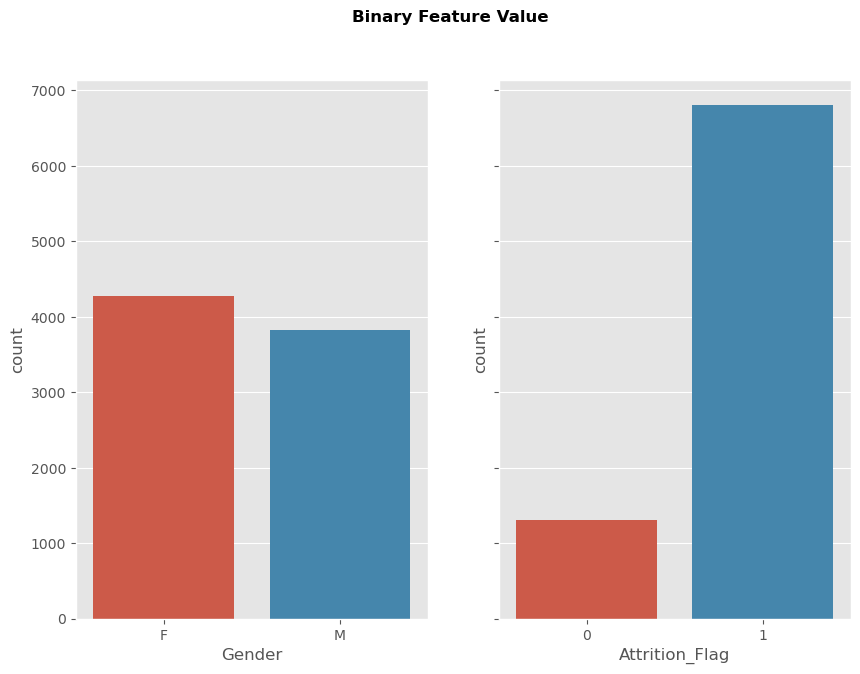

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

for i, col in enumerate(binary_cols):
    ax = axes.flat[i]
    sns.countplot(x= data[col],ax=ax)
plt.suptitle("Binary Feature Value",fontweight='bold')
plt.show()

In [17]:
n_cols = 2

n_rows = plot_template(n_cols,mult_categories_cols)
n_rows

2

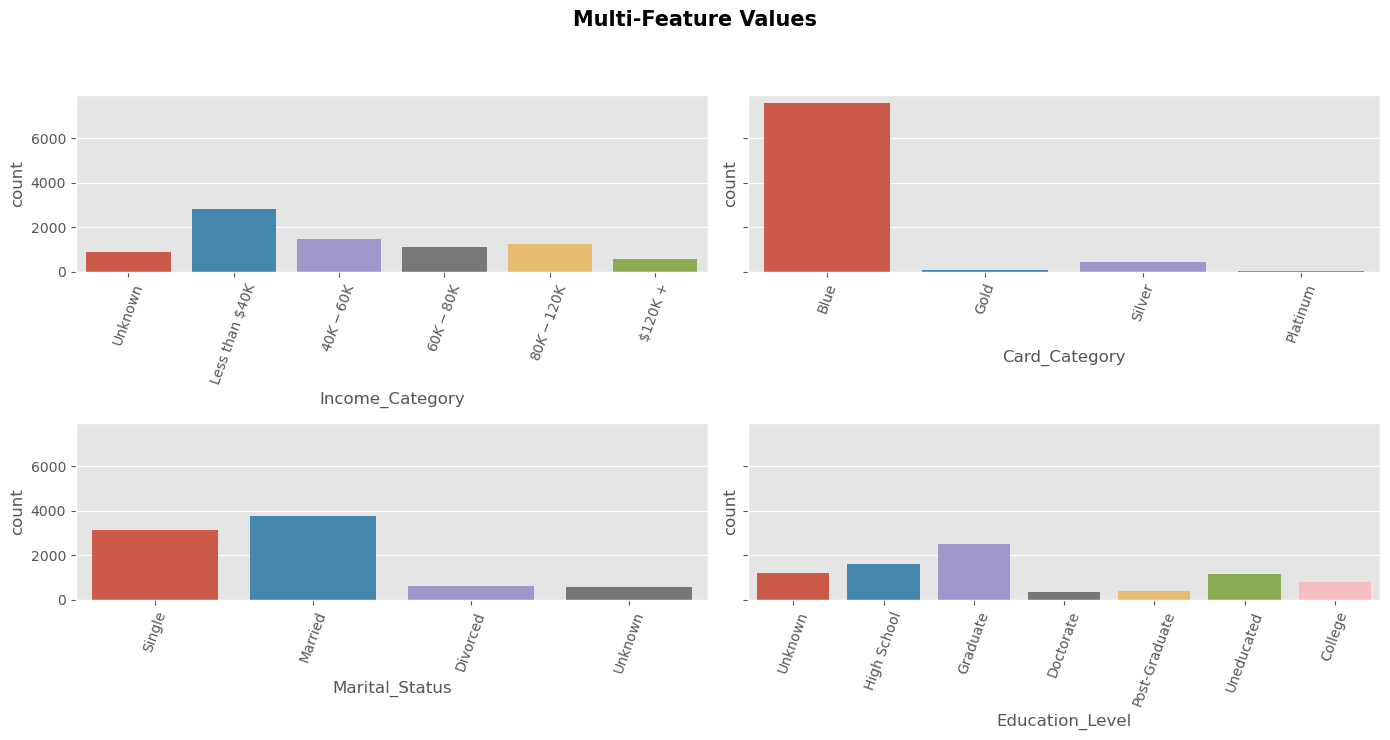

In [18]:
fig, axes = plt.subplots(n_rows,n_cols, figsize=(3.5 * 4, 3.5 *n_rows), sharey=True)

for i, col in enumerate(mult_categories_cols):
    ax = axes.flat[i]
    sns.countplot(x= data[col],ax=ax)
    
    
for ax in axes.flatten():
    plt.sca(ax)
    plt.xticks(rotation = 70)
    
plt.suptitle("Multi-Feature Values", y=1.05,fontsize=15,fontweight='bold')
plt.tight_layout()
plt.show()

In [19]:
n_rows = plot_template(n_cols,numeric_categories_cols)
n_rows

8

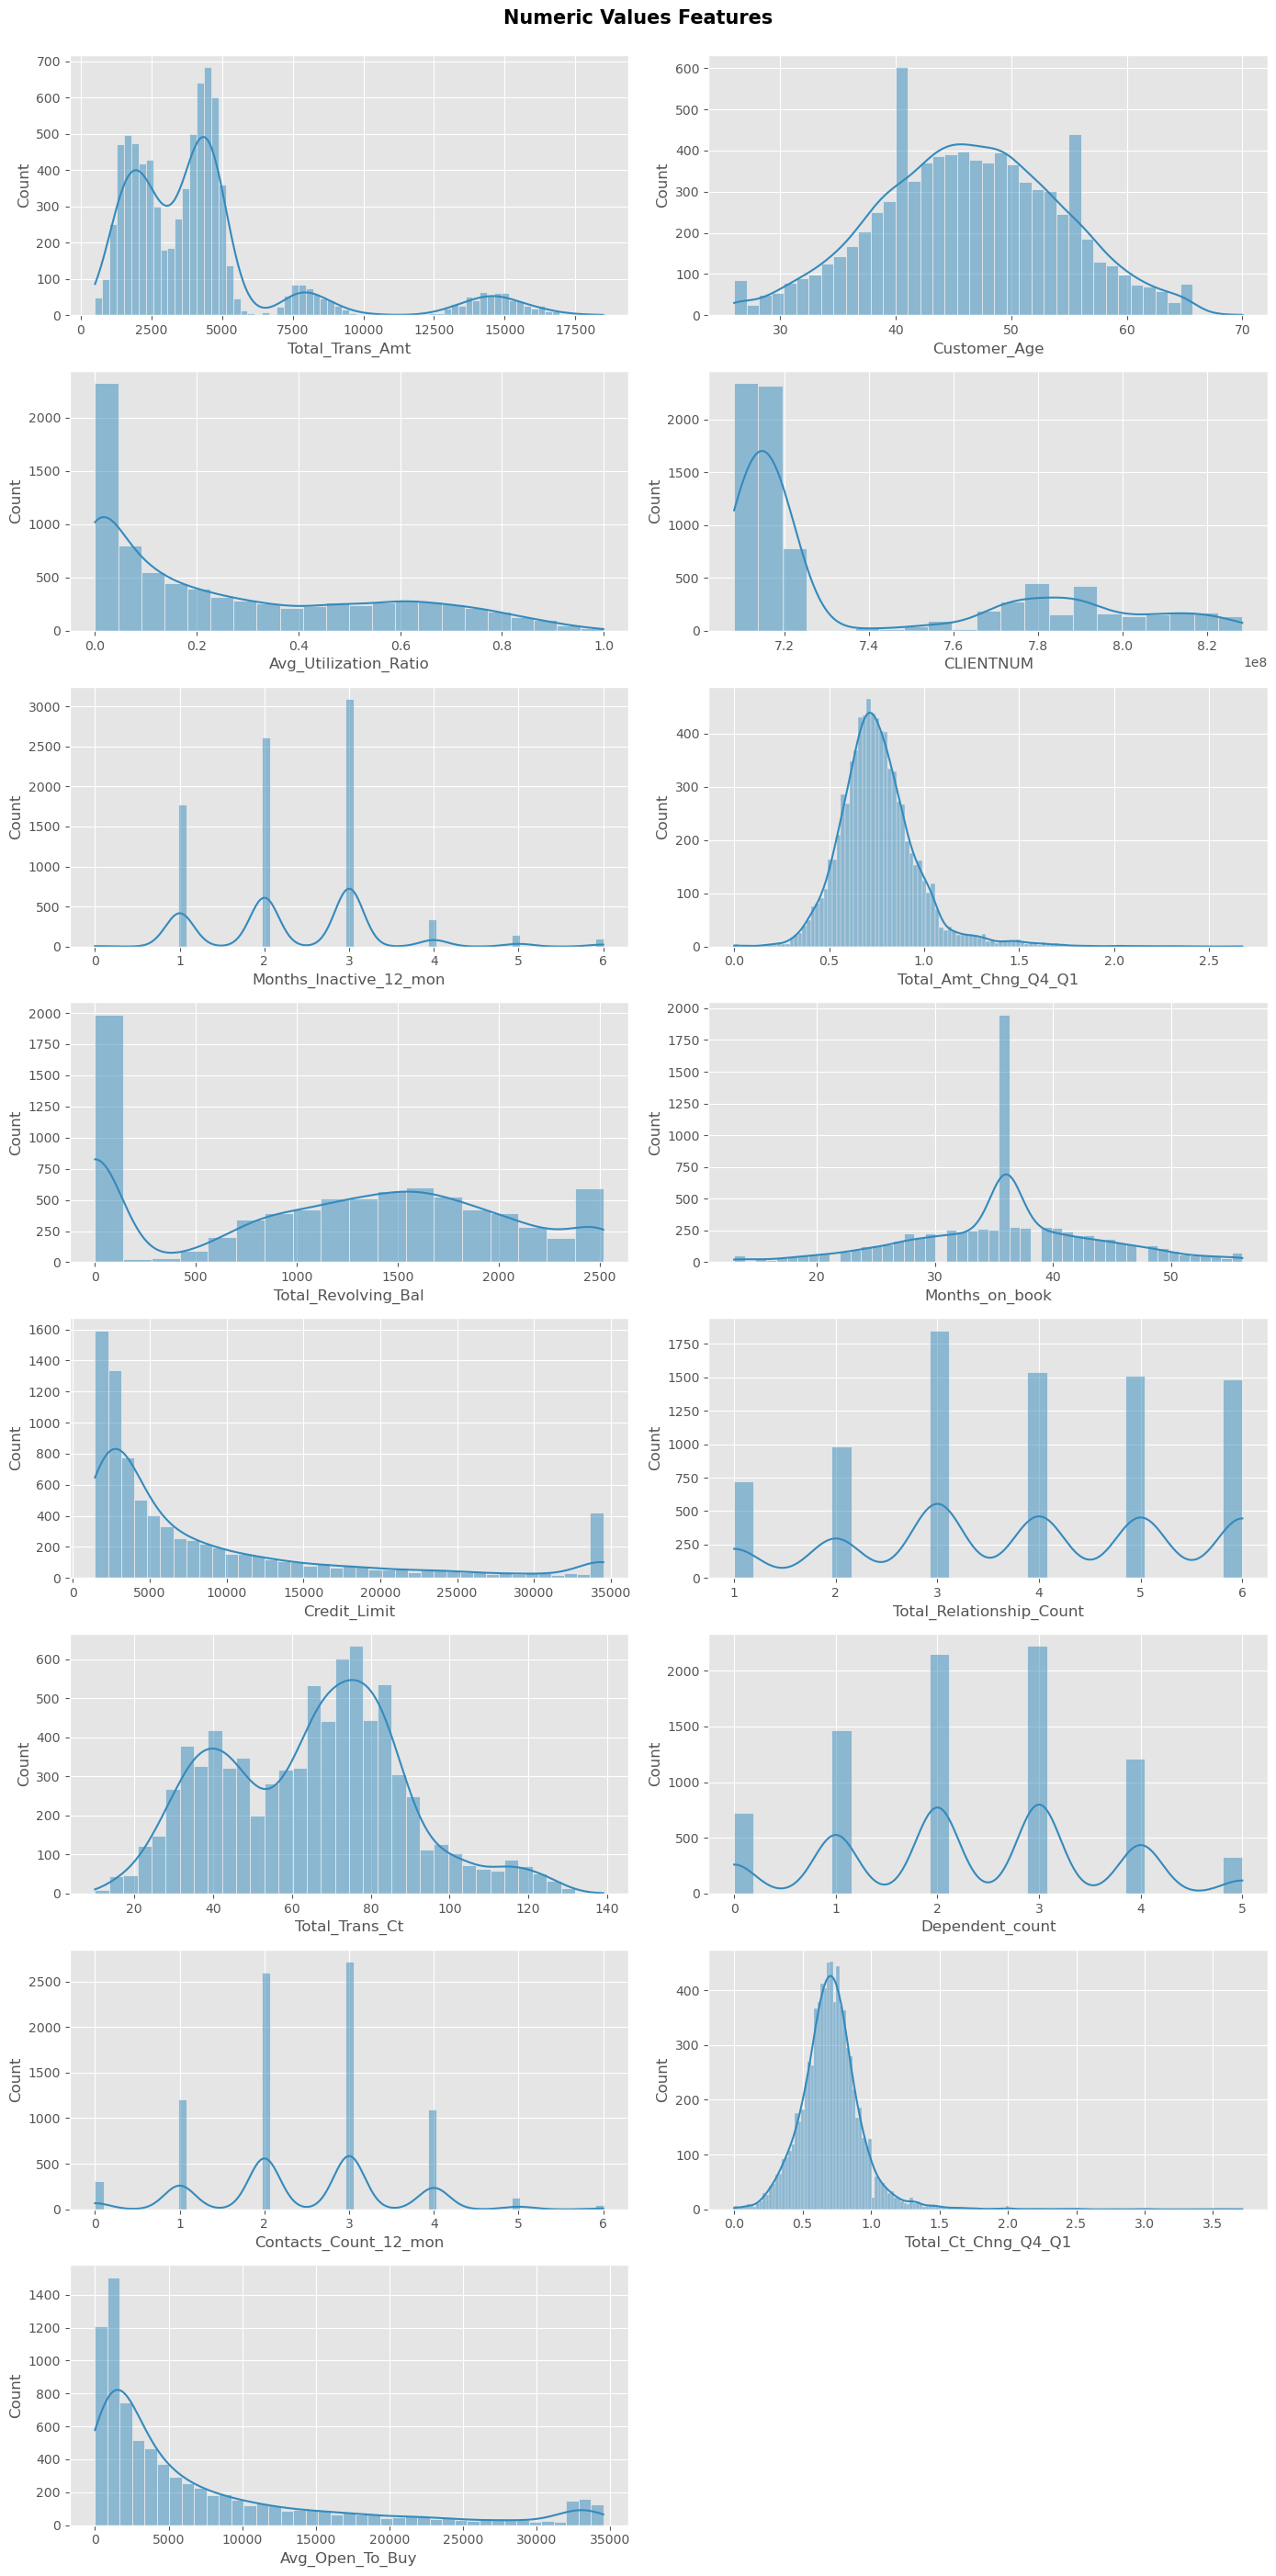

In [20]:
fig, axes = plt.subplots(n_rows,n_cols, figsize=(3.5 * 4, 3.5 *n_rows))

for i, col in enumerate(numeric_categories_cols):
    ax = axes.flat[i]
    sns.histplot(x= data[col],kde=True,ax=ax)
    
plt.suptitle("Numeric Values Features", y=1,fontsize=15,fontweight='bold')
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

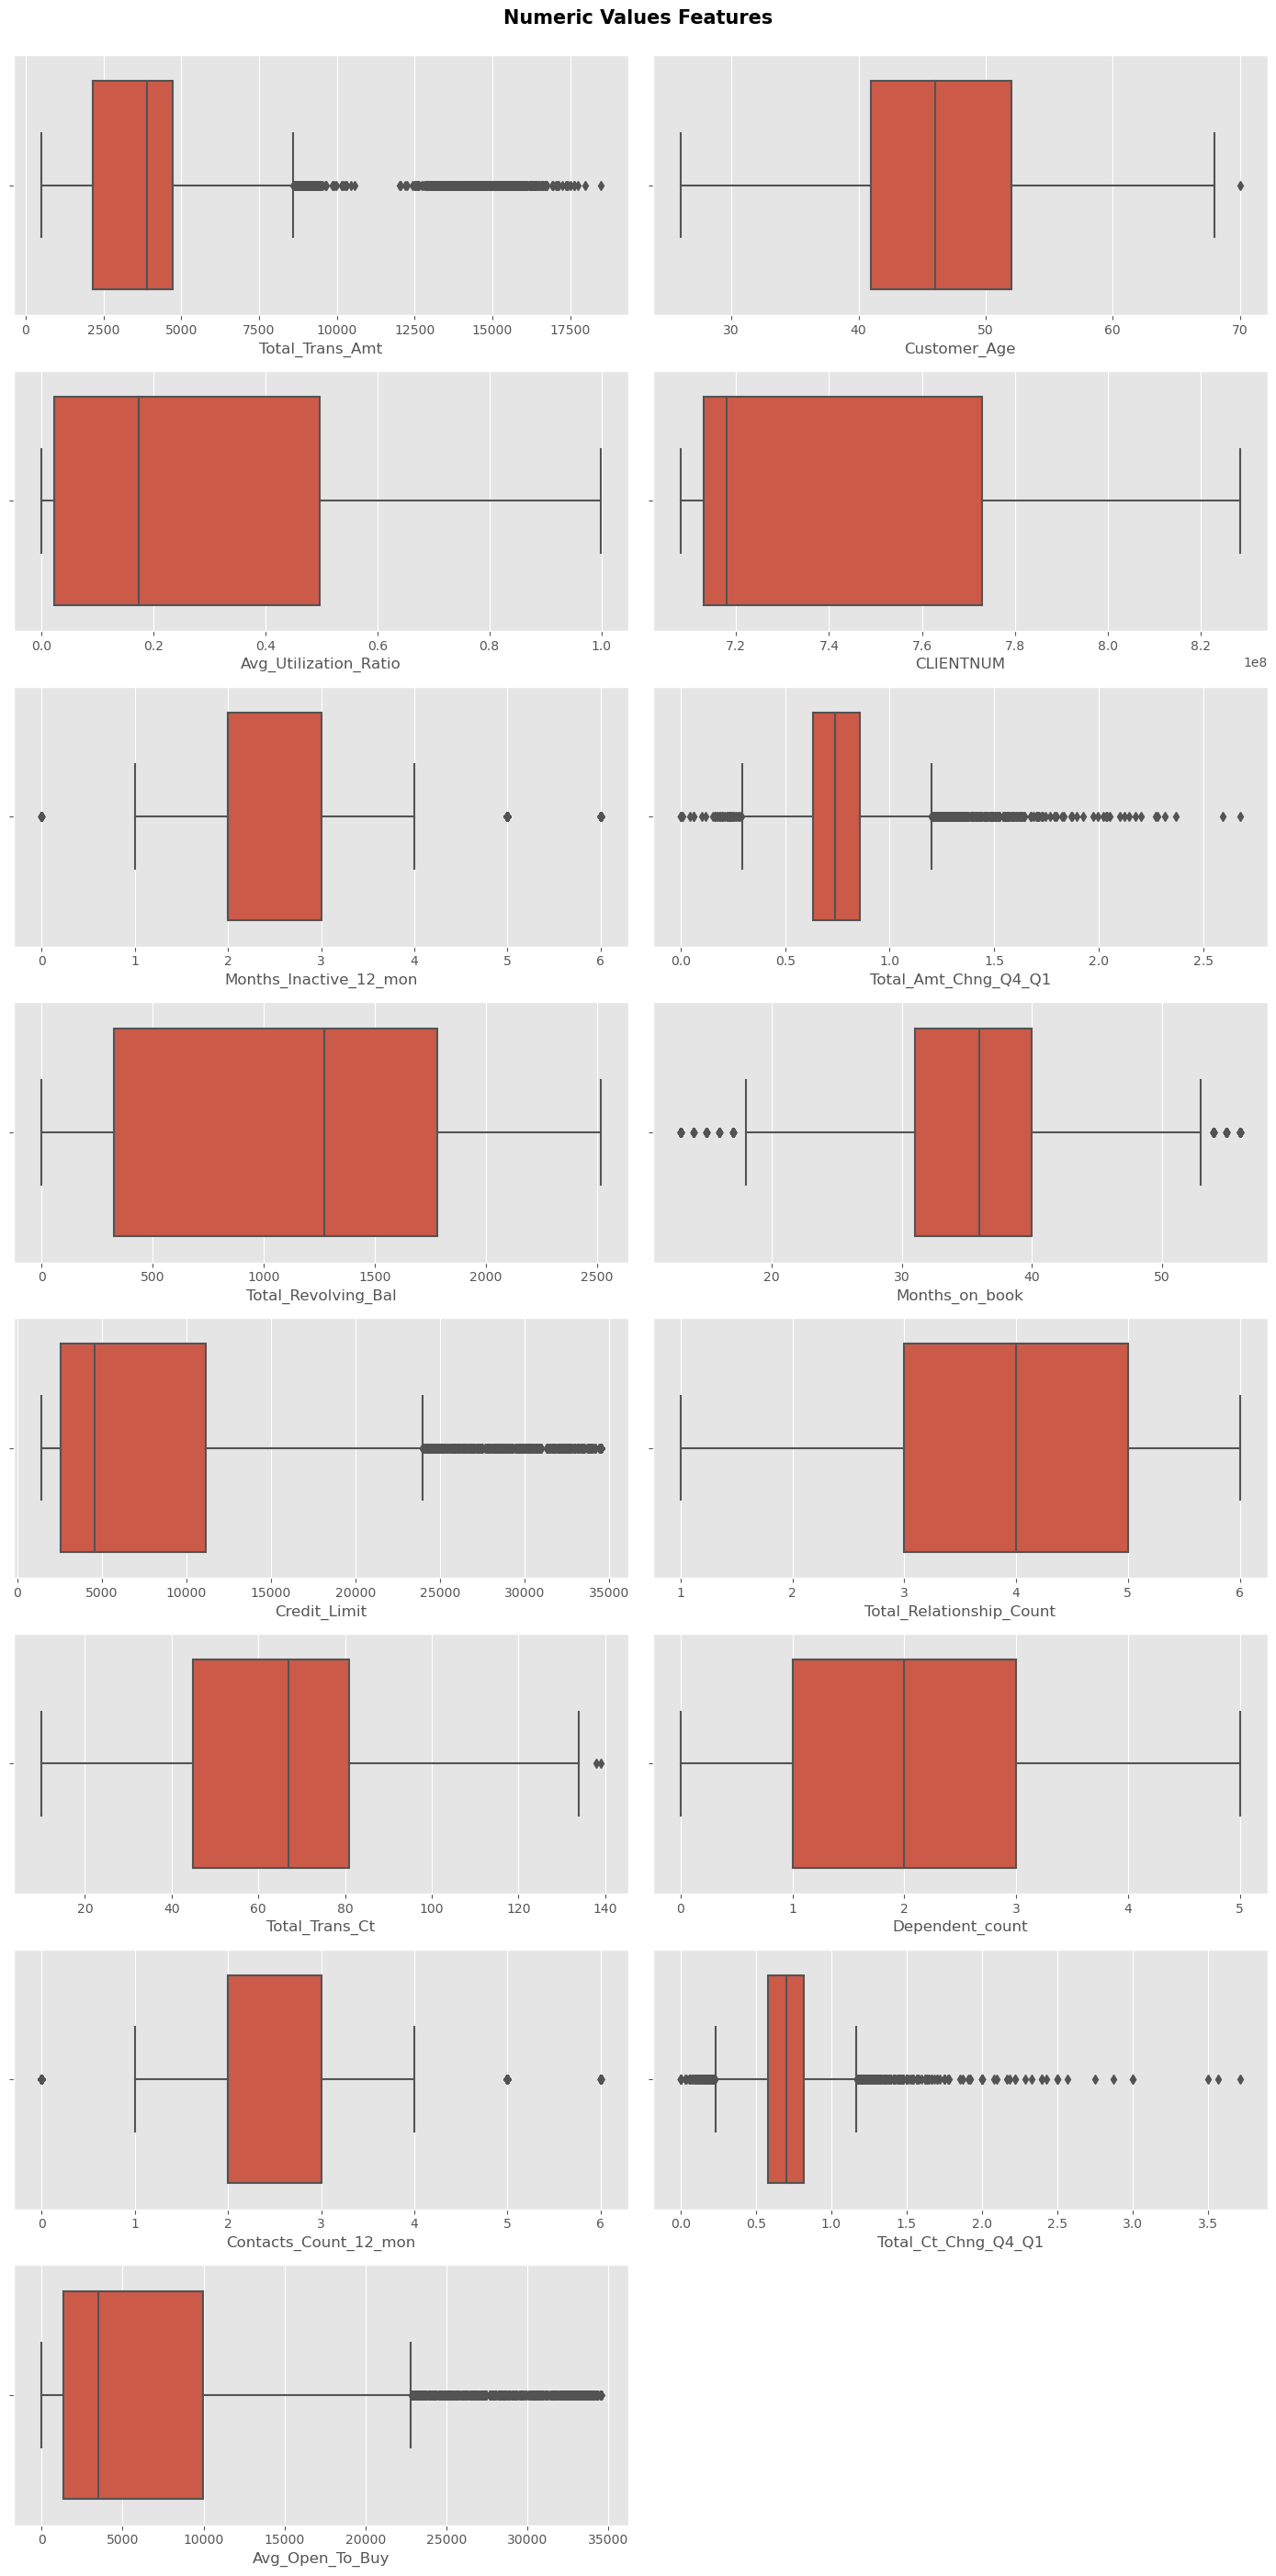

In [21]:
fig, axes = plt.subplots(n_rows,n_cols, figsize=(3.5 * 4, 3.5 *n_rows))

for i, col in enumerate(numeric_categories_cols):
    ax = axes.flat[i]
    sns.boxplot(x= data[col],ax=ax)
    
plt.suptitle("Numeric Values Features", y=1,fontsize=15,fontweight='bold')
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

It would be interesting to see the behavior of the variables with the attrition flag. 

## Categorical Features

In [22]:
gender_attrition = attrited_feature(data,'Attrition_Flag','Gender')
gender_attrition

,Attrition_Flag
Gender,
F,0.823090
M,0.857928


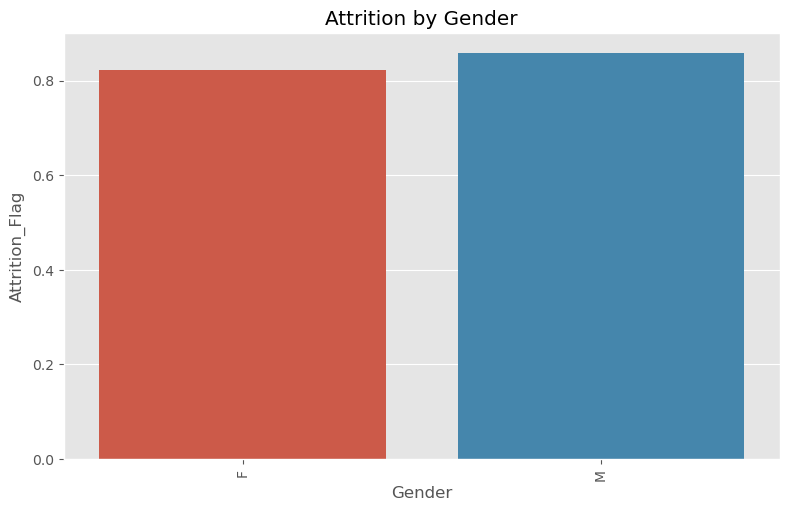

In [23]:
plot_target_attrition(gender_attrition,'Attrition_Flag')

In [24]:
card_category_attrition = attrited_feature(data,'Attrition_Flag',mult_categories_cols[0])
card_category_attrition

,Attrition_Flag
Income_Category,
Unknown,0.821147
Less than $40K,0.827881
$120K +,0.838435
$80K - $120K,0.843977
$40K - $60K,0.851342
$60K - $80K,0.863636


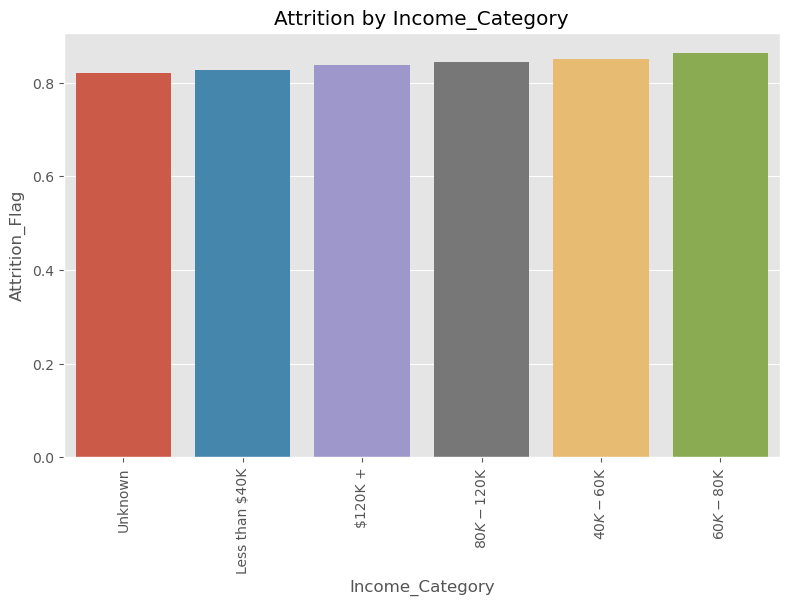

In [25]:
plot_target_attrition(card_category_attrition,'Attrition_Flag')

In [26]:
income_attrition = attrited_feature(data,'Attrition_Flag',mult_categories_cols[1])
income_attrition

,Attrition_Flag
Card_Category,
Platinum,0.666667
Gold,0.827957
Blue,0.838693
Silver,0.862385


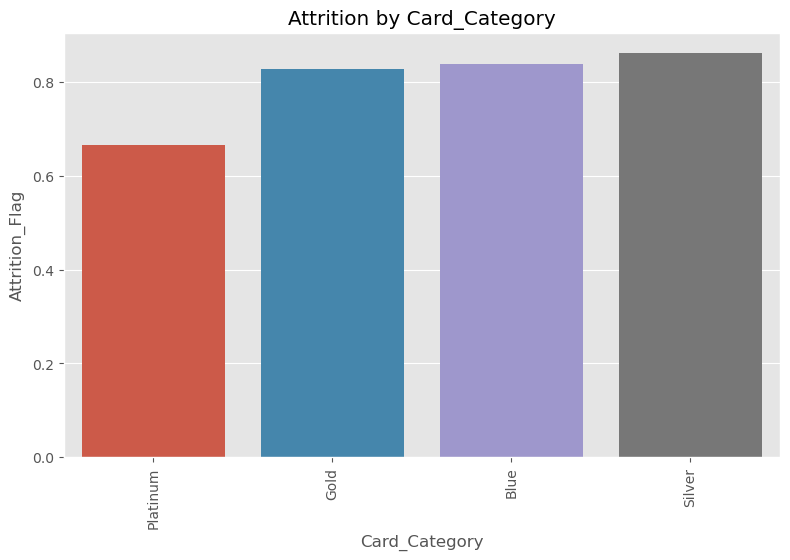

In [27]:
plot_target_attrition(income_attrition,'Attrition_Flag')

In [28]:
education_level_attrition = attrited_feature(data,'Attrition_Flag',mult_categories_cols[2])
education_level_attrition

,Attrition_Flag
Marital_Status,
Divorced,0.831424
Single,0.833333
Unknown,0.835924
Married,0.846562


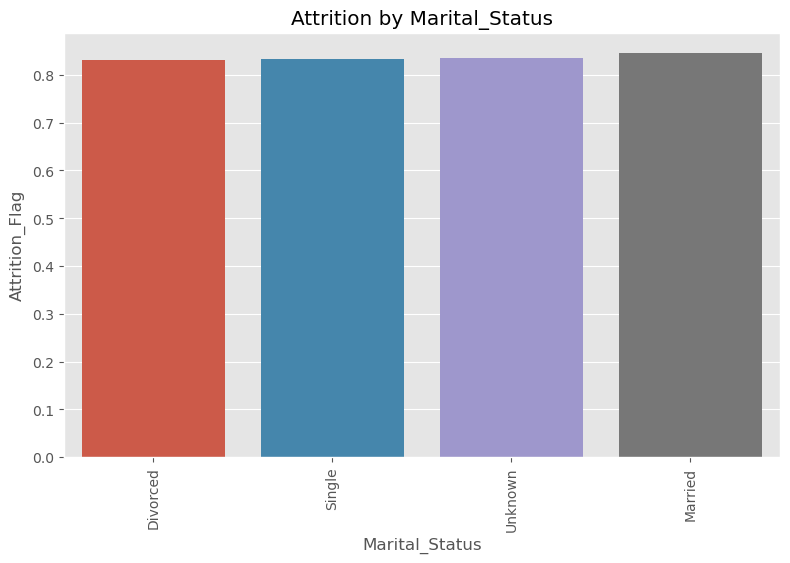

In [29]:
plot_target_attrition(education_level_attrition,'Attrition_Flag')

In [30]:
marital_status_attrition = attrited_feature(data,'Attrition_Flag',mult_categories_cols[3])
marital_status_attrition

,Attrition_Flag
Education_Level,
Doctorate,0.771831
Post-Graduate,0.818182
Unknown,0.831535
Graduate,0.842168
Uneducated,0.845431
High School,0.846819
College,0.860294


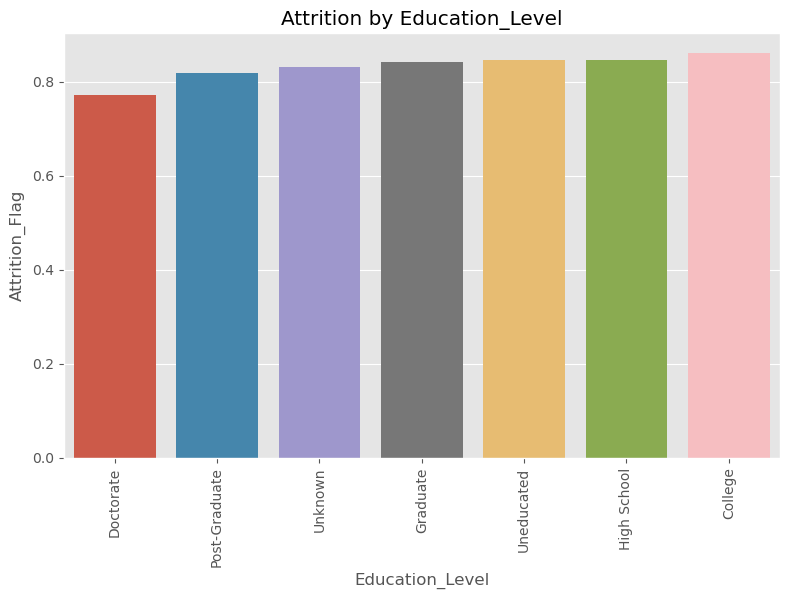

In [31]:
plot_target_attrition(marital_status_attrition,'Attrition_Flag')

## Numeric Features

In [32]:
for i in numeric_categories_cols:
    print(i,attrited_feature(data,'Attrition_Flag',i).describe())

Total_Trans_Amt        Attrition_Flag
count     4462.000000
mean         0.823347
std          0.348259
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Customer_Age        Attrition_Flag
count       44.000000
mean         0.852584
std          0.078781
min          0.500000
25%          0.832231
50%          0.844726
75%          0.874344
max          1.000000
Avg_Utilization_Ratio        Attrition_Flag
count      943.000000
mean         0.881510
std          0.206084
min          0.000000
25%          0.833333
50%          1.000000
75%          1.000000
max          1.000000
CLIENTNUM        Attrition_Flag
count     8101.000000
mean         0.839526
std          0.367068
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Months_Inactive_12_mon        Attrition_Flag
count        7.000000
mean         0.755196
std          0.189499
min          0.363636
25%          0

In [33]:
Dependent_count_attrition = attrited_feature(data,'Attrition_Flag','Dependent_count')
Dependent_count_attrition 

,Attrition_Flag
Dependent_count,
3,0.827183
4,0.834158
5,0.837920
2,0.840930
0,0.846897
1,0.857338


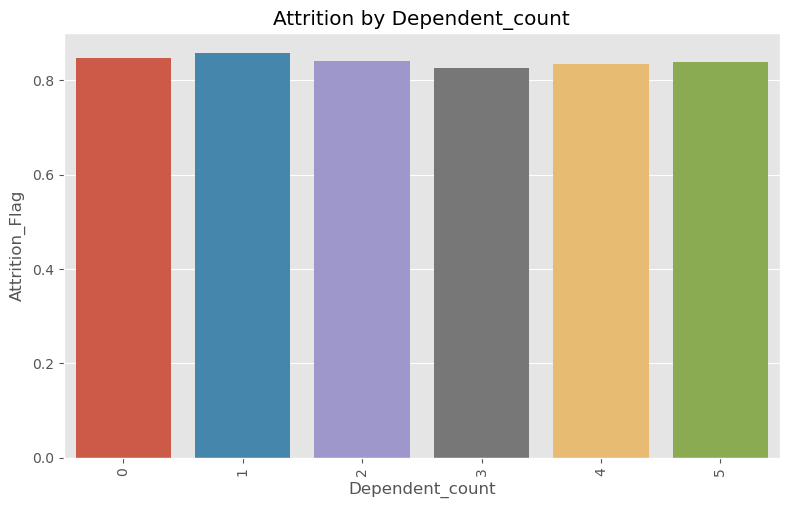

In [34]:
plot_target_attrition(Dependent_count_attrition,'Attrition_Flag')

In [35]:
Contacts_Count_12_mon_attrition = attrited_feature(data,'Attrition_Flag','Contacts_Count_12_mon')
Contacts_Count_12_mon_attrition 

,Attrition_Flag
Contacts_Count_12_mon,
6,0.000000
5,0.676692
4,0.771978
3,0.793446
2,0.879045
1,0.929577
0,0.990385


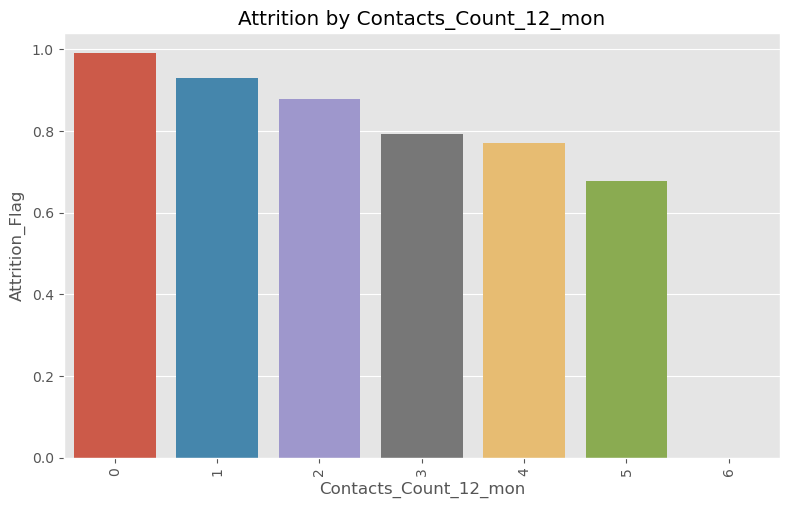

In [36]:
plot_target_attrition(Contacts_Count_12_mon_attrition,'Attrition_Flag')

In [37]:
Total_Trans_Ct_attrition = attrited_feature(data,'Attrition_Flag','Total_Trans_Ct')
Total_Trans_Ct_attrition 

,Attrition_Flag
Total_Trans_Ct,
10,0.000000
12,0.000000
14,0.000000
17,0.166667
15,0.200000
...,...
108,1.000000
109,1.000000
110,1.000000


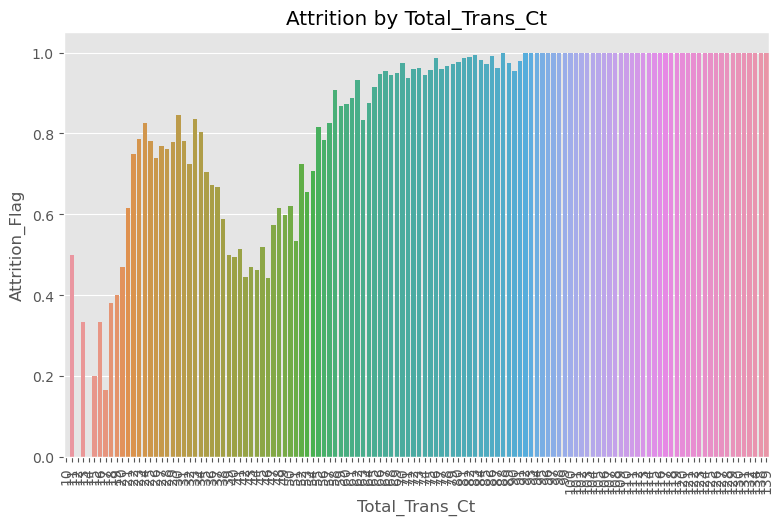

In [38]:
plot_target_attrition(Total_Trans_Ct_attrition,'Attrition_Flag')

In [39]:
Total_Relationship_Count_attrition = attrited_feature(data,'Attrition_Flag','Total_Relationship_Count')
Total_Relationship_Count_attrition 

,Attrition_Flag
Total_Relationship_Count,
2,0.722843
1,0.746556
3,0.825594
4,0.876543
5,0.882197
6,0.897849


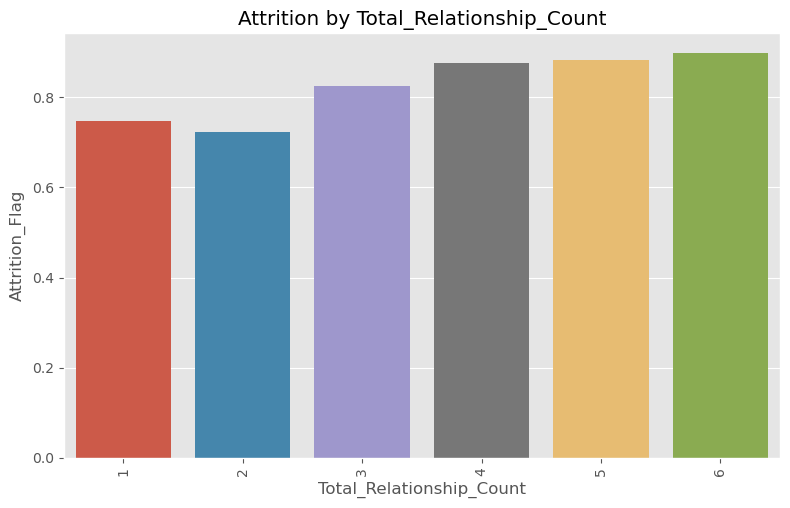

In [40]:
plot_target_attrition(Total_Relationship_Count_attrition,'Attrition_Flag')

In [41]:
Months_on_book_attrition = attrited_feature(data,'Attrition_Flag','Months_on_book')
Months_on_book_attrition

,Attrition_Flag
Months_on_book,
15,0.714286
50,0.735632
51,0.765625
52,0.788462
39,0.800725
44,0.802139
18,0.804348
30,0.813043
41,0.814815


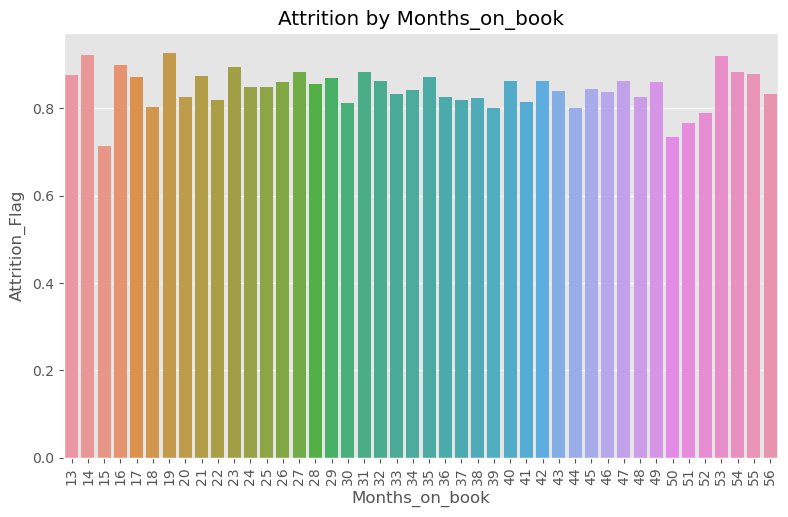

In [42]:
plot_target_attrition(Months_on_book_attrition,'Attrition_Flag')

In [43]:
Months_Inactive_12_mon_attrition = attrited_feature(data,'Attrition_Flag','Months_Inactive_12_mon')
Months_Inactive_12_mon_attrition

,Attrition_Flag
Months_Inactive_12_mon,
0,0.363636
4,0.696532
3,0.785391
5,0.798611
6,0.836538
2,0.849483
1,0.956180


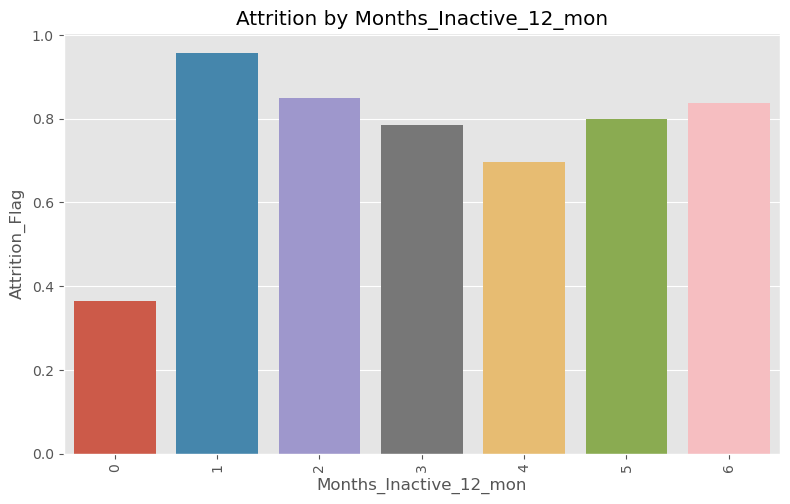

In [44]:
plot_target_attrition(Months_Inactive_12_mon_attrition,'Attrition_Flag')

In [45]:
Customer_Age_attrition = attrited_feature(data,'Attrition_Flag','Customer_Age')
Customer_Age_attrition

,Attrition_Flag
Customer_Age,
68,0.500000
59,0.735537
54,0.779592
61,0.794521
62,0.800000
55,0.811404
41,0.814570
43,0.816712
48,0.817204


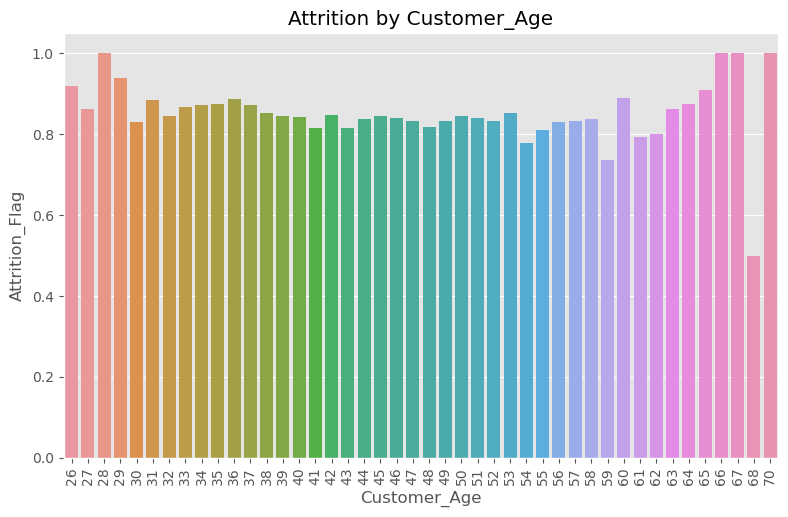

In [46]:
plot_target_attrition(Customer_Age_attrition,'Attrition_Flag')

In [47]:
Total_Trans_Amt_attrition = attrited_feature(data,'Attrition_Flag','Total_Trans_Amt')
Total_Trans_Amt_attrition

,Attrition_Flag
Total_Trans_Amt,
510,0.0
2430,0.0
2427,0.0
2426,0.0
2424,0.0
...,...
3693,1.0
3694,1.0
3695,1.0


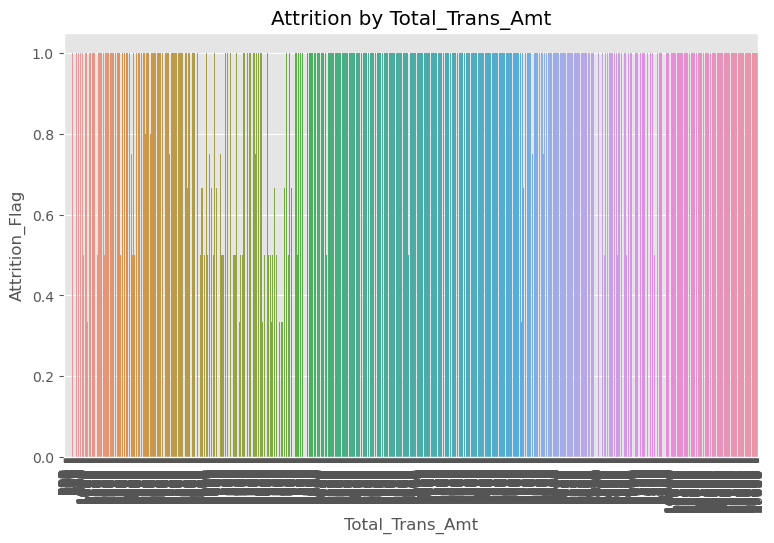

In [48]:
plot_target_attrition( Total_Trans_Amt_attrition,'Attrition_Flag')

In [49]:
Total_Amt_Chng_Q4_Q1_attrition = attrited_feature(data,'Attrition_Flag','Total_Amt_Chng_Q4_Q1')
Total_Amt_Chng_Q4_Q1_attrition

,Attrition_Flag
Total_Amt_Chng_Q4_Q1,
0.000,0.0
0.439,0.0
0.304,0.0
0.305,0.0
1.203,0.0
...,...
1.065,1.0
1.064,1.0
1.063,1.0


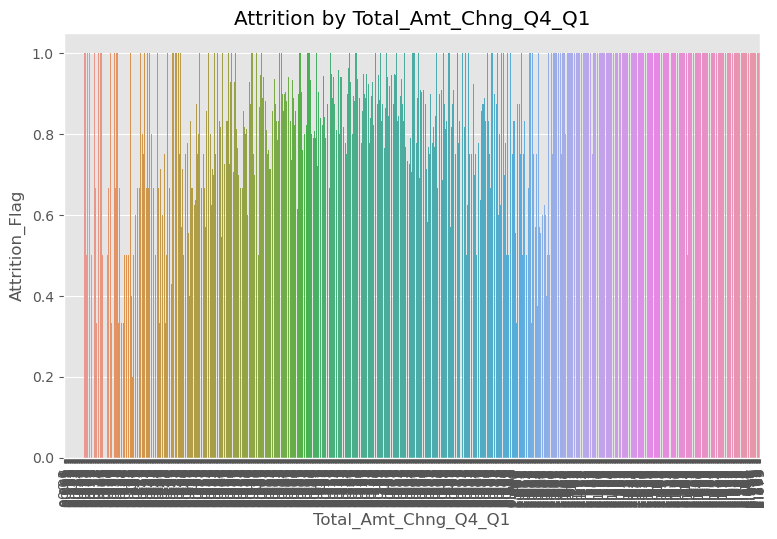

In [50]:
plot_target_attrition(Total_Amt_Chng_Q4_Q1_attrition,'Attrition_Flag')

# Split the Data

In [51]:
X = data.drop(columns=['CLIENTNUM','Attrition_Flag'])
y = data['Attrition_Flag']
seed = 13

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Preprocessing Data

In [53]:
cat_cols.columns.to_list()

['Gender',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category']

In [54]:
#encode the categorical values
enc = ce.TargetEncoder(cols=cat_cols.columns,smoothing=11).fit(X_train[cat_cols.columns],y_train)
X_train[cat_cols.columns] = enc.transform(X_train[cat_cols.columns])

In [55]:
X_test[cat_cols.columns] = enc.transform(X_test[cat_cols.columns])

In [56]:
X_train.head().T

train_idx,802,4121,3083,6160,509
Customer_Age,45.000000,55.000000,29.000000,47.000000,41.000000
Gender,0.855063,0.824137,0.855063,0.855063,0.855063
Dependent_count,3.000000,1.000000,0.000000,5.000000,2.000000
Education_Level,0.843642,0.843642,0.843642,0.859177,0.836798
Marital_Status,0.828299,0.828299,0.846585,0.846585,0.828299
Income_Category,0.863014,0.823635,0.863014,0.829218,0.838614
Card_Category,0.838528,0.838528,0.838528,0.838528,0.838528
Months_on_book,38.000000,42.000000,36.000000,34.000000,28.000000
Total_Relationship_Count,1.000000,6.000000,3.000000,3.000000,1.000000
Months_Inactive_12_mon,3.000000,3.000000,3.000000,1.000000,2.000000


In [57]:
#scaler = StandardScaler()
scaler = RobustScaler()

# transform data
X_train[X_train.columns] = scaler.fit_transform(X_train)
X_test[X_test.columns] = scaler.transform(X_test)

In [58]:
n_rows = plot_template(n_cols,X_train.columns)
n_rows

10

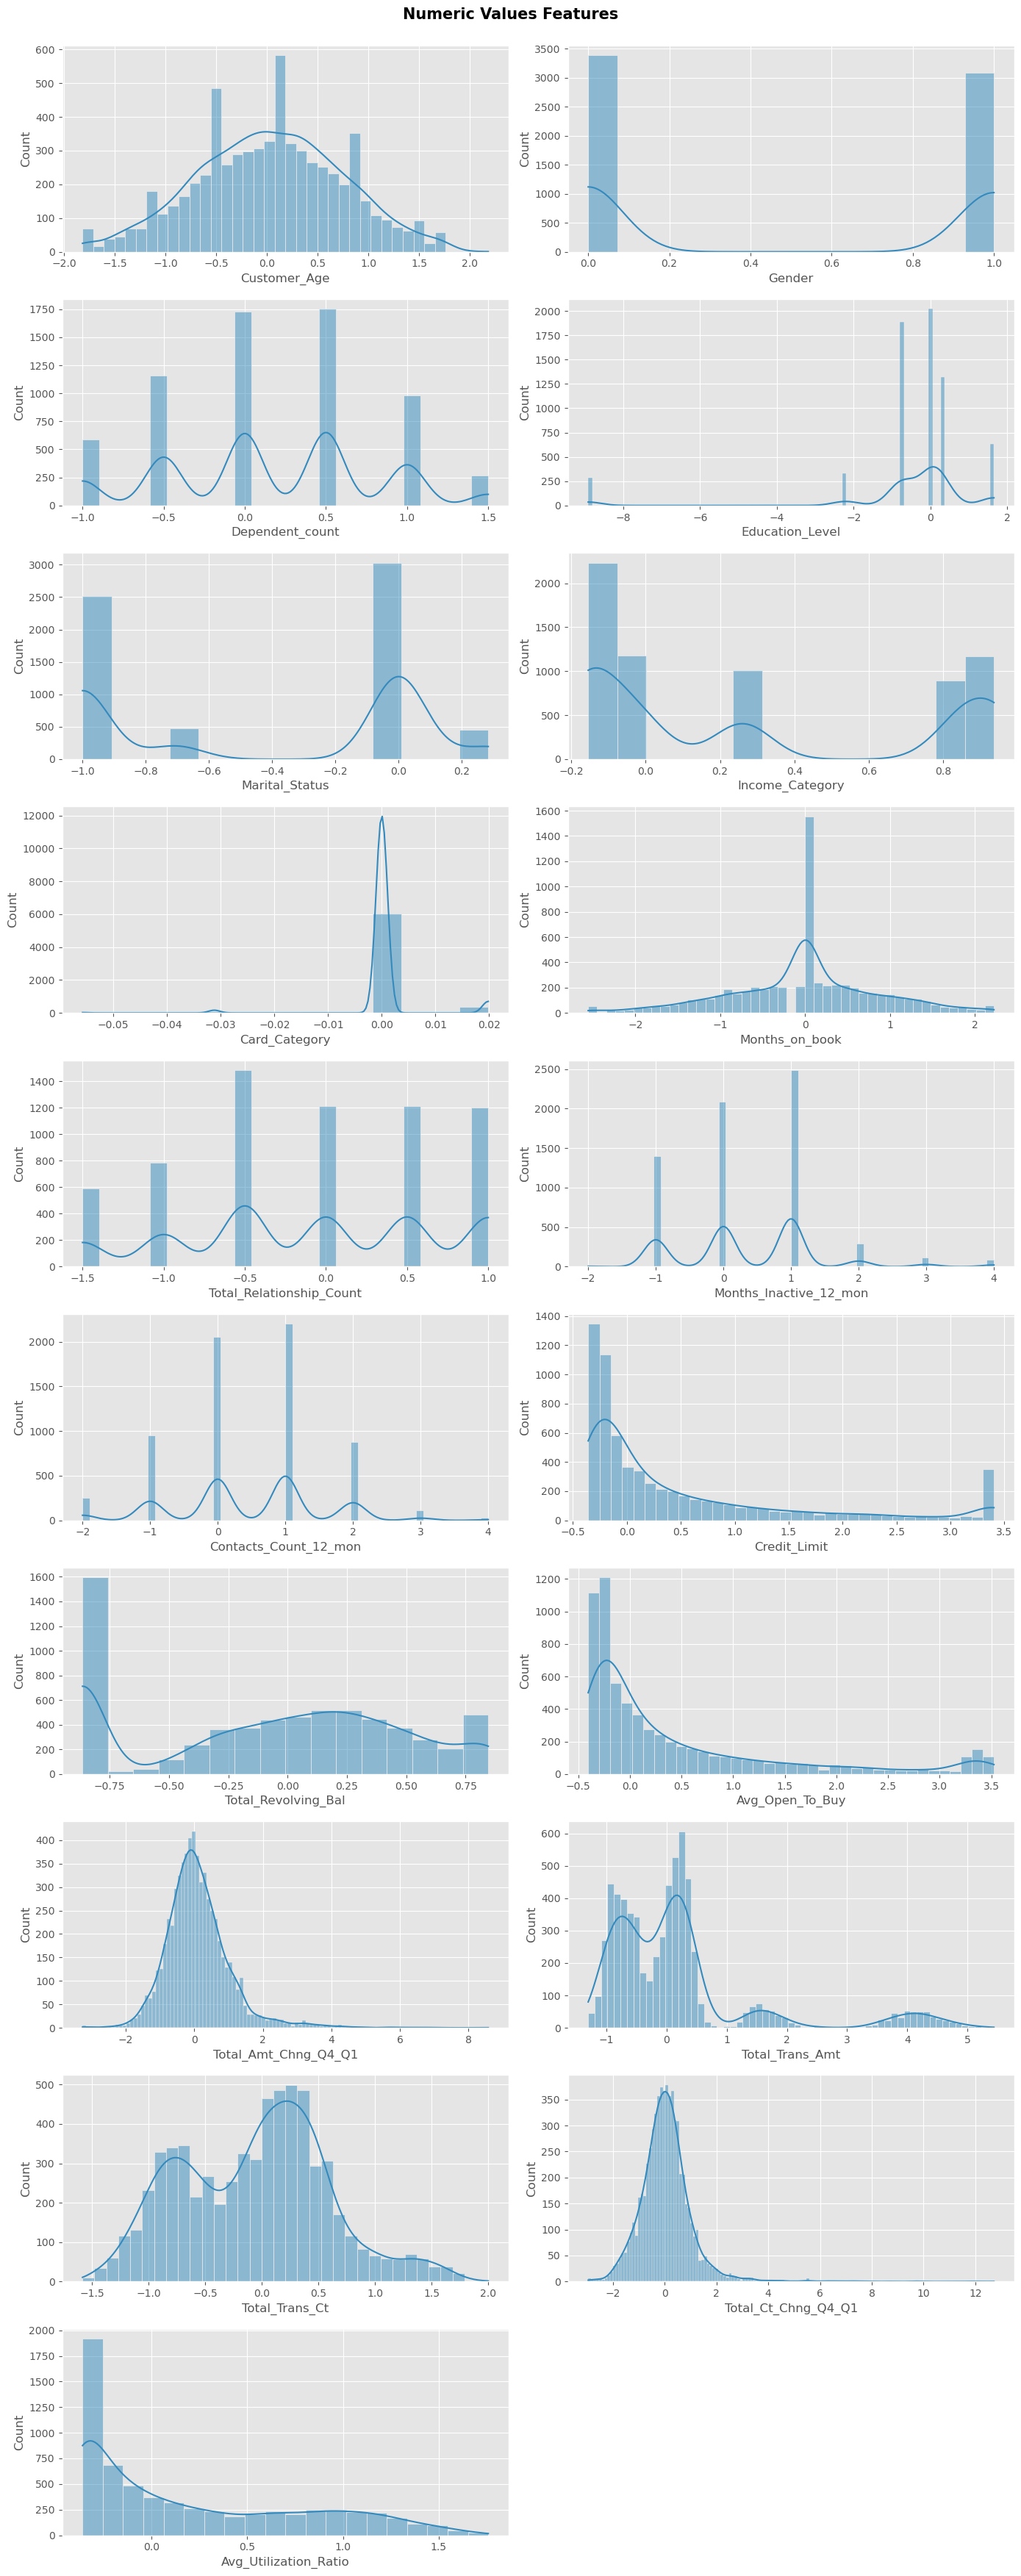

In [59]:
fig, axes = plt.subplots(n_rows,n_cols, figsize=(3.5 * 4, 3.5 *n_rows))

for i, col in enumerate(X_train):
    ax = axes.flat[i]
    sns.histplot(x= X_train[col],kde=True,ax=ax)
    
plt.suptitle("Numeric Values Features", y=1,fontsize=15,fontweight='bold')
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

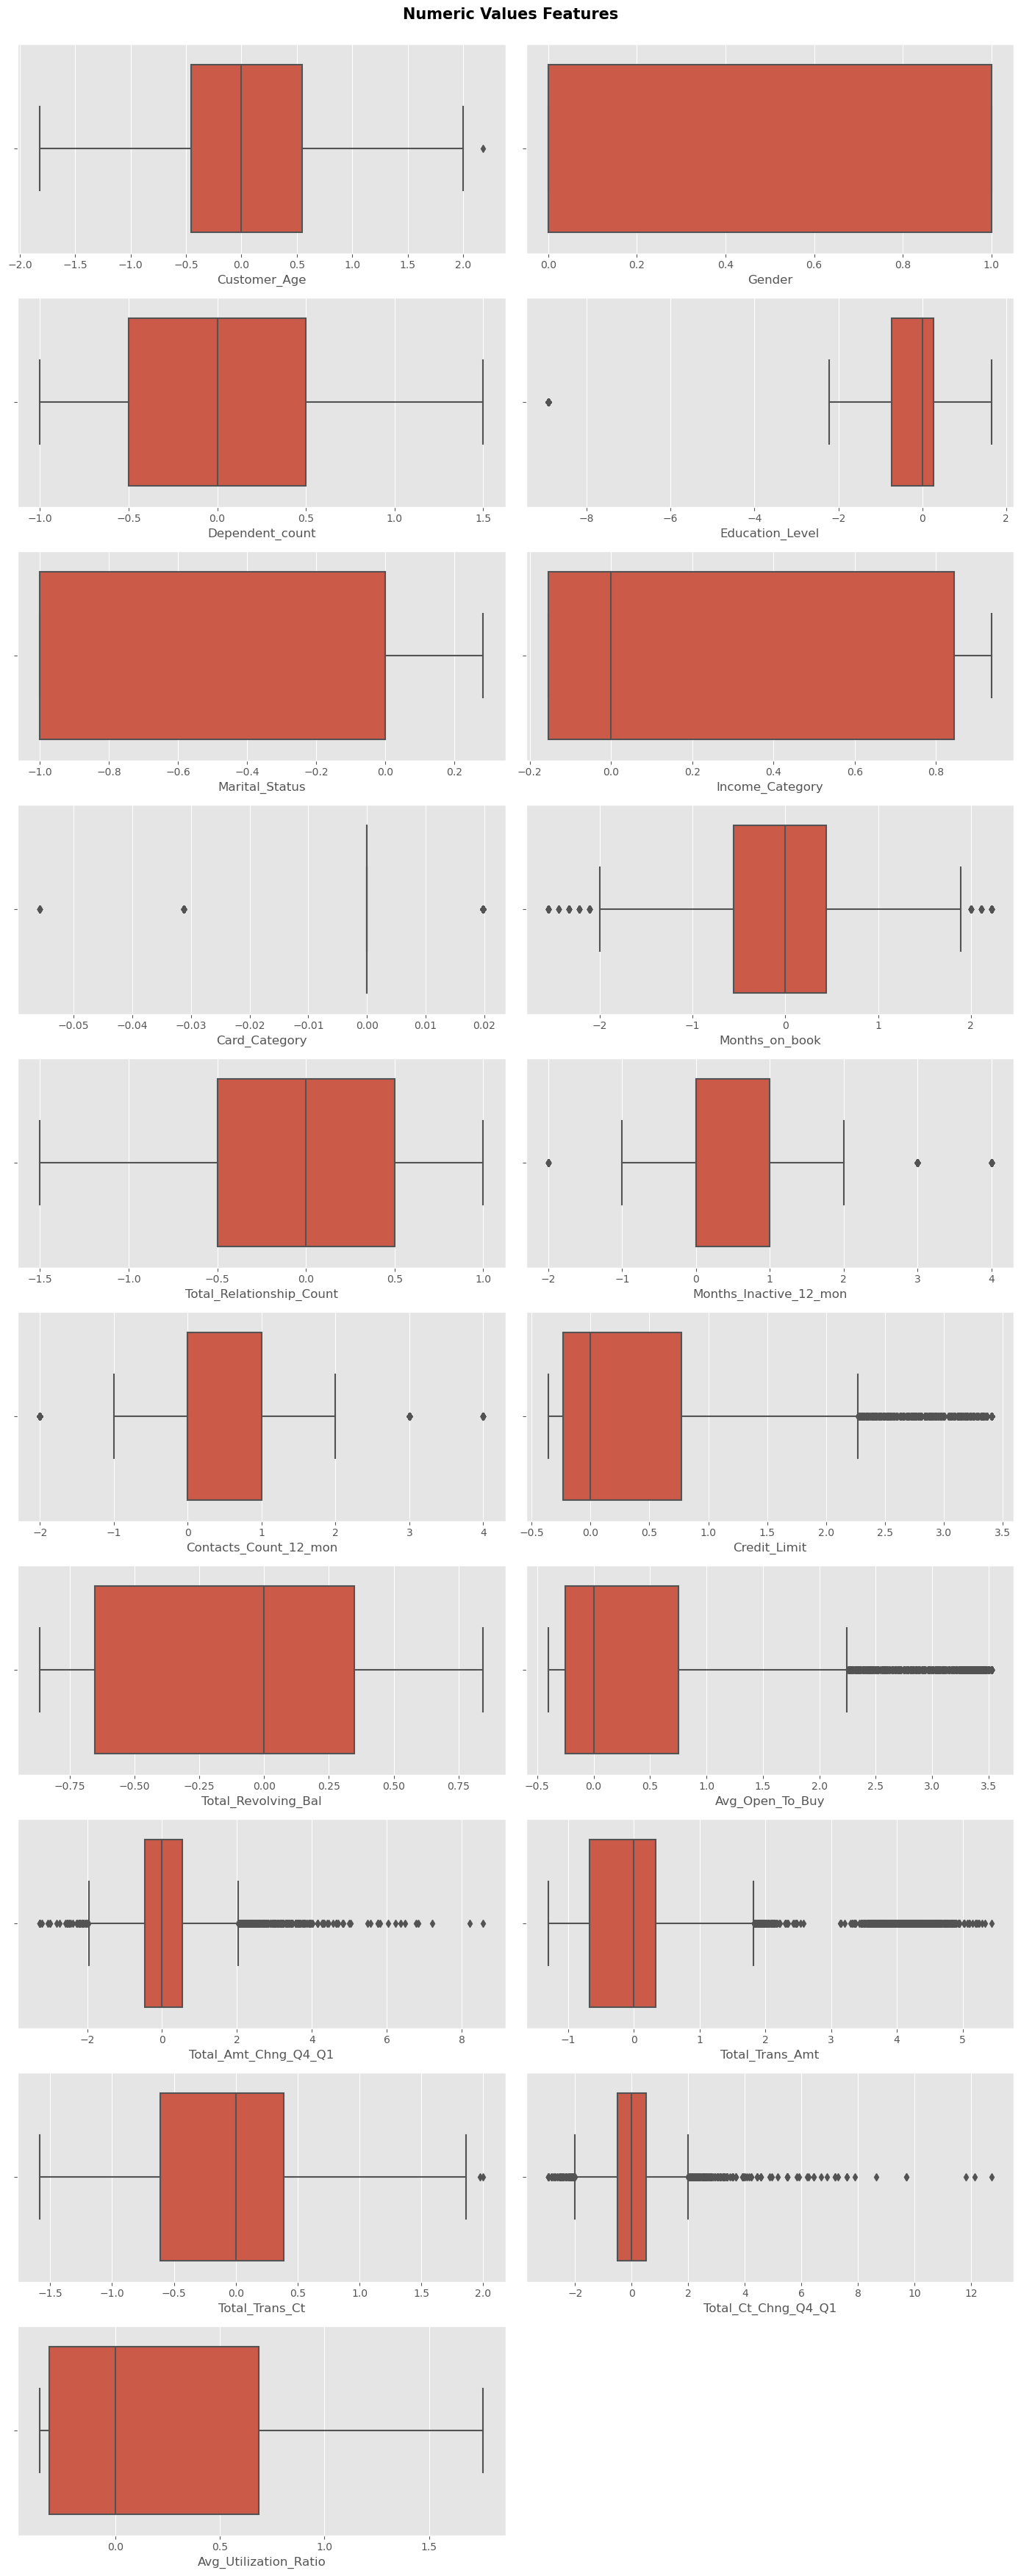

In [60]:
fig, axes = plt.subplots(n_rows,n_cols, figsize=(3.5 * 4, 3.5 *n_rows))

for i, col in enumerate(X_train.columns):
    ax = axes.flat[i]
    sns.boxplot(x= X_train[col],ax=ax)
    
plt.suptitle("Numeric Values Features", y=1,fontsize=15,fontweight='bold')
axes[-1, -1].axis('off')
plt.tight_layout()
plt.show()

 # Balance Data

In [61]:
over = SMOTE(sampling_strategy='not majority',random_state=17)
under = RandomUnderSampler(sampling_strategy='not majority')
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

X_train_sm,y_train_sm = pipeline.fit_resample(X_train,y_train)

In [62]:
X_train_sm.shape[0],y_train_sm.shape[0],X_test.shape[0],y_test.shape[0]

(10872, 10872, 1621, 1621)

# Feature Selection

<Figure size 1000x600 with 0 Axes>

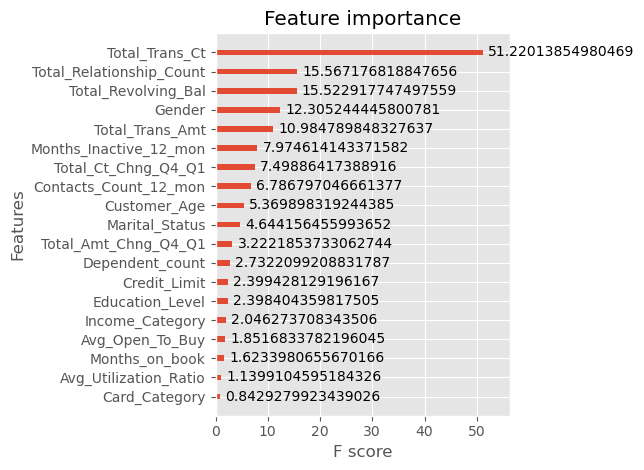

In [63]:
features = XGBClassifier()
features.fit(X_train_sm, y_train_sm)

plt.figure(figsize=(10,6))
plot_importance(features,height=0.3,importance_type='gain')
plt.tight_layout()
plt.show()

In [64]:
features_importance_names = features.get_booster().get_score(importance_type='gain')
features_importance_names

{'Customer_Age': 5.369898319244385,
 'Gender': 12.305244445800781,
 'Dependent_count': 2.7322099208831787,
 'Education_Level': 2.398404359817505,
 'Marital_Status': 4.644156455993652,
 'Income_Category': 2.046273708343506,
 'Card_Category': 0.8429279923439026,
 'Months_on_book': 1.6233980655670166,
 'Total_Relationship_Count': 15.567176818847656,
 'Months_Inactive_12_mon': 7.974614143371582,
 'Contacts_Count_12_mon': 6.786797046661377,
 'Credit_Limit': 2.399428129196167,
 'Total_Revolving_Bal': 15.522917747497559,
 'Avg_Open_To_Buy': 1.8516833782196045,
 'Total_Amt_Chng_Q4_Q1': 3.2221853733062744,
 'Total_Trans_Amt': 10.984789848327637,
 'Total_Trans_Ct': 51.22013854980469,
 'Total_Ct_Chng_Q4_Q1': 7.49886417388916,
 'Avg_Utilization_Ratio': 1.1399104595184326}

In [65]:
#use function (5) to get the tupple from the list and then sort it
features_importance_names_list = list(features_importance_names.items())
features_importance_names_list.sort(key = get_value,reverse=True)

In [66]:
features_importance_names_list

[('Total_Trans_Ct', 51.22013854980469),
 ('Total_Relationship_Count', 15.567176818847656),
 ('Total_Revolving_Bal', 15.522917747497559),
 ('Gender', 12.305244445800781),
 ('Total_Trans_Amt', 10.984789848327637),
 ('Months_Inactive_12_mon', 7.974614143371582),
 ('Total_Ct_Chng_Q4_Q1', 7.49886417388916),
 ('Contacts_Count_12_mon', 6.786797046661377),
 ('Customer_Age', 5.369898319244385),
 ('Marital_Status', 4.644156455993652),
 ('Total_Amt_Chng_Q4_Q1', 3.2221853733062744),
 ('Dependent_count', 2.7322099208831787),
 ('Credit_Limit', 2.399428129196167),
 ('Education_Level', 2.398404359817505),
 ('Income_Category', 2.046273708343506),
 ('Avg_Open_To_Buy', 1.8516833782196045),
 ('Months_on_book', 1.6233980655670166),
 ('Avg_Utilization_Ratio', 1.1399104595184326),
 ('Card_Category', 0.8429279923439026)]

In [67]:
#get only the first value of the tupple
features_sorted_names = [] 

for i in features_importance_names_list:
    features_sorted_names.append(i[0])

features_sorted_names

['Total_Trans_Ct',
 'Total_Relationship_Count',
 'Total_Revolving_Bal',
 'Gender',
 'Total_Trans_Amt',
 'Months_Inactive_12_mon',
 'Total_Ct_Chng_Q4_Q1',
 'Contacts_Count_12_mon',
 'Customer_Age',
 'Marital_Status',
 'Total_Amt_Chng_Q4_Q1',
 'Dependent_count',
 'Credit_Limit',
 'Education_Level',
 'Income_Category',
 'Avg_Open_To_Buy',
 'Months_on_book',
 'Avg_Utilization_Ratio',
 'Card_Category']

In [74]:
#define the columns with least value
drop_cols = features_sorted_names[9:]
drop_cols

['Marital_Status',
 'Total_Amt_Chng_Q4_Q1',
 'Dependent_count',
 'Credit_Limit',
 'Education_Level',
 'Income_Category',
 'Avg_Open_To_Buy',
 'Months_on_book',
 'Avg_Utilization_Ratio',
 'Card_Category']

In [75]:
X_train_ = X_train_sm.drop(columns=drop_cols)
y_train_ = y_train_sm

In [76]:
X_test_ = X_test.drop(columns=drop_cols)
y_test_ = y_test

# Model Creation

## Random Forest

In [77]:
rf = RandomForestClassifier(random_state= seed)

In [78]:
 # Hyperparameter Tuning
parameters_rf = {
    'n_estimators': [10,100, 200,500], 
    'max_depth' : [2, 5, 7,10,20,25],
    'min_samples_split': [12,20,40],
    'criterion':['gini', 'entropy'],
    'bootstrap': [True, False]
}

In [79]:
skfold = StratifiedKFold(n_splits=6,shuffle=True,random_state=seed)

In [80]:
gridRf = GridSearchCV(rf, parameters_rf, cv=skfold)

In [81]:
y_rf_score = gridRf.fit(X_train_, y_train_) 

In [82]:
gridRf.best_score_

0.9734179543782192

In [83]:
#best parameters
gridRf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 20,
 'min_samples_split': 12,
 'n_estimators': 500}

In [84]:
best_stimator_grid_rf = gridRf.best_estimator_
best_stimator_grid_rf

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=20,
                       min_samples_split=12, n_estimators=500, random_state=13)

In [85]:
y_rf_pred = gridRf.predict(X_test_) 

In [86]:
report_rf = classification_report(y_test_, y_rf_pred,output_dict=True)
df_report_rf = pd.DataFrame(report_rf).T
df_report_rf

,precision,recall,f1-score,support
0,0.890196,0.886719,0.888454,256.000000
1,0.978770,0.979487,0.979129,1365.000000
accuracy,0.964837,0.964837,0.964837,0.964837
macro avg,0.934483,0.933103,0.933791,1621.000000
weighted avg,0.964782,0.964837,0.964809,1621.000000


In [87]:
#Confusion matrix
conf_matrix_rf = confusion_matrix(y_test_, y_rf_pred)
#Accuracy
acu_rf = accuracy_score(y_test_, y_rf_pred)
#AUC
auc_rf = roc_auc_score(y_test_, y_rf_pred)

In [88]:
acmod_rf = {"RF_y_test":round(acu_rf,4)}
aucmod_rf = {"RF_y_test":round(auc_rf,4)}

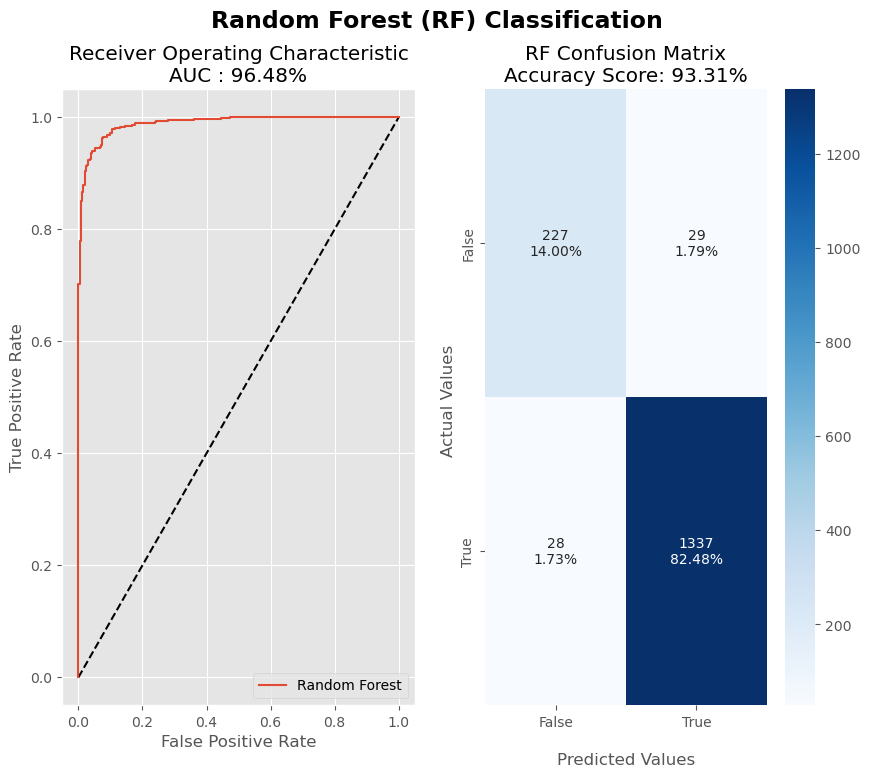

In [89]:
#run the functiona (4)
subplots_ROC_CM("Random Forest (RF) Classification","Receiver Operating Characteristic",
                "RF Confusion Matrix",
                gridRf.best_estimator_,acmod_rf,aucmod_rf,conf_matrix_rf,"RF_y_test",X_test_,y_test_,"Random Forest") 

## Stochastic Gradient Descent (SDG)

In [90]:
sdg = SGDClassifier(random_state= seed)

In [91]:
# Hyperparameter Tuning
parameters_sdg = {
    'penalty':['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant','optimal','invscaling','adaptive'],
    'loss': ['log_loss','modified_huber'],
    'alpha': list(range(1,50,1)) ,
    'fit_intercept': [True,False],
    'max_iter': [5000]
    
}

In [92]:
gridSdg = GridSearchCV(sdg, parameters_sdg, cv=skfold)

In [93]:
y_sdg_score = gridSdg.fit(X_train_, y_train_) 

/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
12348 fits failed out of a total of 14112.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10584 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 883, in fit
    return self._fit(
  File "/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_stochastic_gradient.py", line 649, in _fit
    self._validate_params()
  File "/opt/anacond

In [94]:
gridSdg.best_score_

0.8084988962472406

In [95]:
#best parameters
gridSdg.best_params_

{'alpha': 1,
 'fit_intercept': True,
 'learning_rate': 'optimal',
 'loss': 'modified_huber',
 'max_iter': 5000,
 'penalty': 'l2'}

In [96]:
best_estimator_grid_sdg = gridSdg.best_estimator_
best_estimator_grid_sdg

SGDClassifier(alpha=1, loss='modified_huber', max_iter=5000, random_state=13)

In [97]:
y_sdg_pred = gridSdg.predict(X_test_) 

In [98]:
report_sdg = classification_report(y_test_, y_sdg_pred,output_dict=True)
df_report_sdg = pd.DataFrame(report_sdg).T
df_report_sdg

,precision,recall,f1-score,support
0,0.506143,0.804688,0.621418,256.000000
1,0.958814,0.852747,0.902675,1365.000000
accuracy,0.845157,0.845157,0.845157,0.845157
macro avg,0.732478,0.828717,0.762047,1621.000000
weighted avg,0.887325,0.845157,0.858257,1621.000000


In [99]:
#Confusion matrix
conf_matrix_sdg = confusion_matrix(y_test, y_sdg_pred)
#Accuracy
acu_sdg = accuracy_score(y_test, y_sdg_pred)
#AUC
auc_sdg = roc_auc_score(y_test, y_sdg_pred)

In [100]:
acmod_sdg = {"SDG_y_test":round(acu_sdg,4)}
aucmod_sdg = {"SDG_y_test":round(auc_sdg,4)}

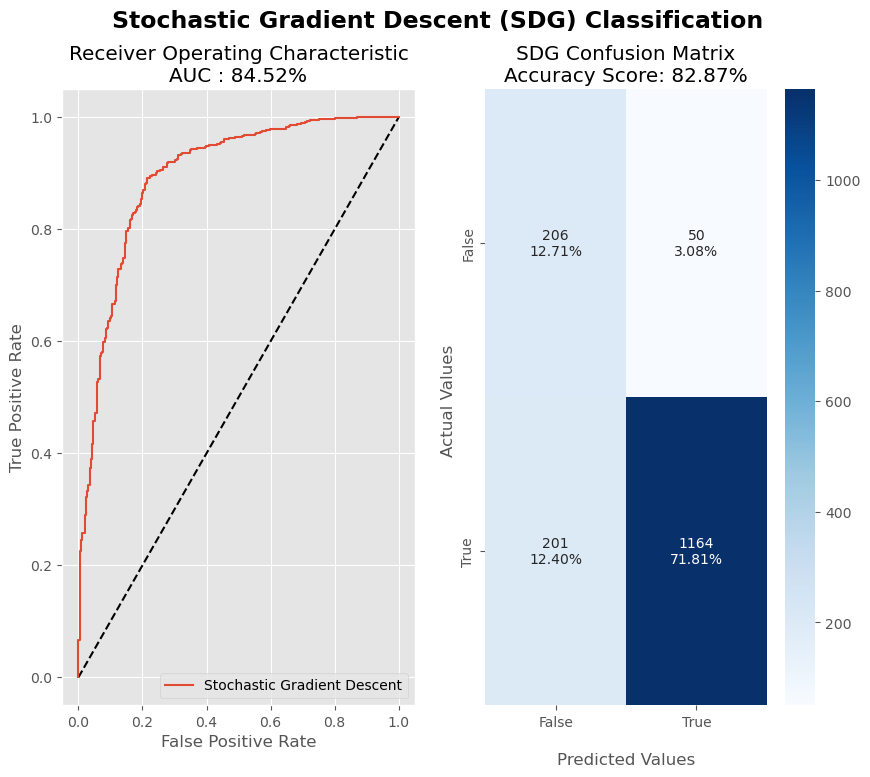

In [101]:
#run the functiona (4)
subplots_ROC_CM("Stochastic Gradient Descent (SDG) Classification","Receiver Operating Characteristic",
                "SDG Confusion Matrix",
                gridSdg.best_estimator_,acmod_sdg,aucmod_sdg,conf_matrix_sdg,"SDG_y_test",X_test_,y_test_,"Stochastic Gradient Descent") 

## XGBoost 

In [102]:
xgbc = XGBClassifier(random_state= seed)

In [103]:
# Hyperparameter Tuning
parameters_xgbc = {
              'objective':['binary:logistic'],
              'learning_rate': [0.0001,0.001,0.01,0.1],
              'max_depth': [2,4,7,15], 
              'subsample': [0.1,0.5,0.8],
              'colsample_bytree': [0.1,0.5,0.7],
              'n_estimators': [100,300,500,1000],
}

In [104]:
gridXgbc = GridSearchCV(xgbc, parameters_xgbc, cv=skfold)

In [105]:
 y_xgbc_score = gridXgbc.fit(X_train_, y_train_) 

In [106]:
 gridXgbc.best_score_

0.978476821192053

In [107]:
#best parameters
gridXgbc.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.1,
 'max_depth': 15,
 'n_estimators': 500,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [108]:
best_estimator_grid_xgbc = gridXgbc.best_estimator_
best_estimator_grid_xgbc

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=500, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=13, ...)

In [109]:
y_xgbc_pred = gridXgbc.predict(X_test_) 

In [110]:
report_xgbc = classification_report(y_test_, y_xgbc_pred,output_dict=True)
df_report_xgbc = pd.DataFrame(report_xgbc).T
df_report_xgbc

,precision,recall,f1-score,support
0,0.917695,0.871094,0.893788,256.000000
1,0.976052,0.985348,0.980678,1365.000000
accuracy,0.967304,0.967304,0.967304,0.967304
macro avg,0.946874,0.928221,0.937233,1621.000000
weighted avg,0.966836,0.967304,0.966956,1621.000000


In [111]:
#Confusion matrix
conf_matrix_xgbc = confusion_matrix(y_test_, y_xgbc_pred)
#Accuracy
acu_xgbc = accuracy_score(y_test_, y_xgbc_pred)
#AUC
auc_xgbc = roc_auc_score(y_test_, y_xgbc_pred)

In [112]:
acmod_xgbc = {"XGBC_y_test":round(acu_xgbc,4)}
aucmod_xgbc = {"XGBC_y_test":round(auc_xgbc,4)}

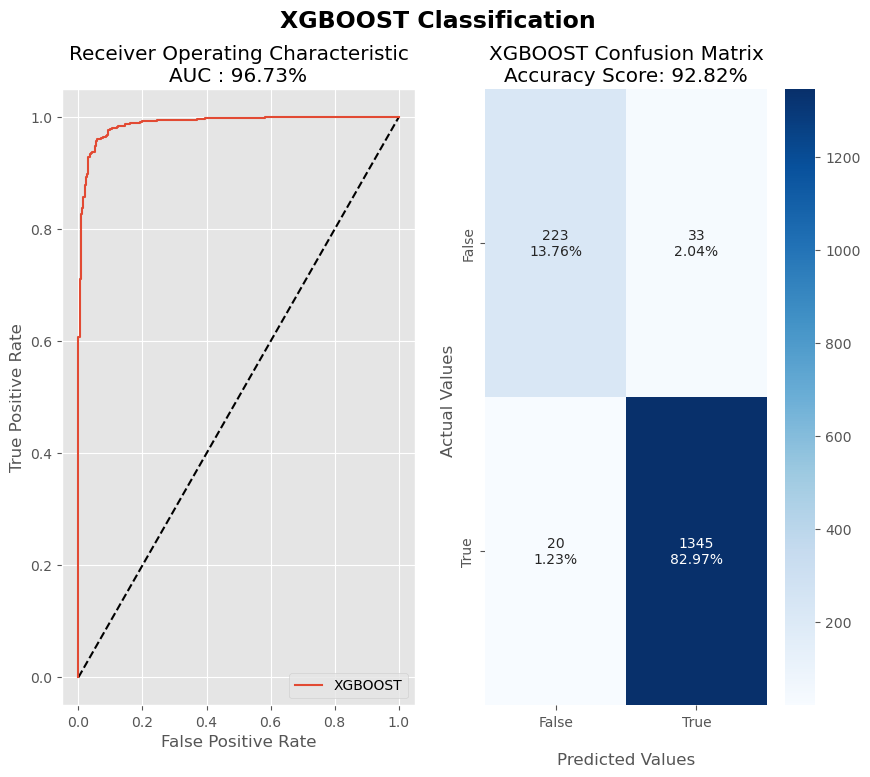

In [113]:
#run the functiona (9)
subplots_ROC_CM("XGBOOST Classification","Receiver Operating Characteristic",
                "XGBOOST Confusion Matrix",
                gridXgbc.best_estimator_,acmod_xgbc,aucmod_xgbc,conf_matrix_xgbc,"XGBC_y_test",X_test_,y_test_,"XGBOOST") 

# Select Model

In [138]:
Accuracy = {"RF":acu_rf,"SDG":acu_sdg,"XGBC":acu_xgbc}
AUC = {"RF":auc_rf,"SDG":auc_sdg,"XGBC":auc_xgbc}
F1_score = {"RF":df_report_rf.iloc[3,2],
            "SDG":df_report_sdg.iloc[3,2],"XGBC":df_report_xgbc.iloc[3,2]}

In [139]:
df_report_rf

,precision,recall,f1-score,support
0,0.890196,0.886719,0.888454,256.000000
1,0.978770,0.979487,0.979129,1365.000000
accuracy,0.964837,0.964837,0.964837,0.964837
macro avg,0.934483,0.933103,0.933791,1621.000000
weighted avg,0.964782,0.964837,0.964809,1621.000000


In [140]:
metrics_models = pd.DataFrame([Accuracy,AUC,F1_score],index=["Accuracy","AUC","F1"]).T
metrics_models

,Accuracy,AUC,F1
RF,0.964837,0.933103,0.933791
SDG,0.845157,0.828717,0.762047
XGBC,0.967304,0.928221,0.937233


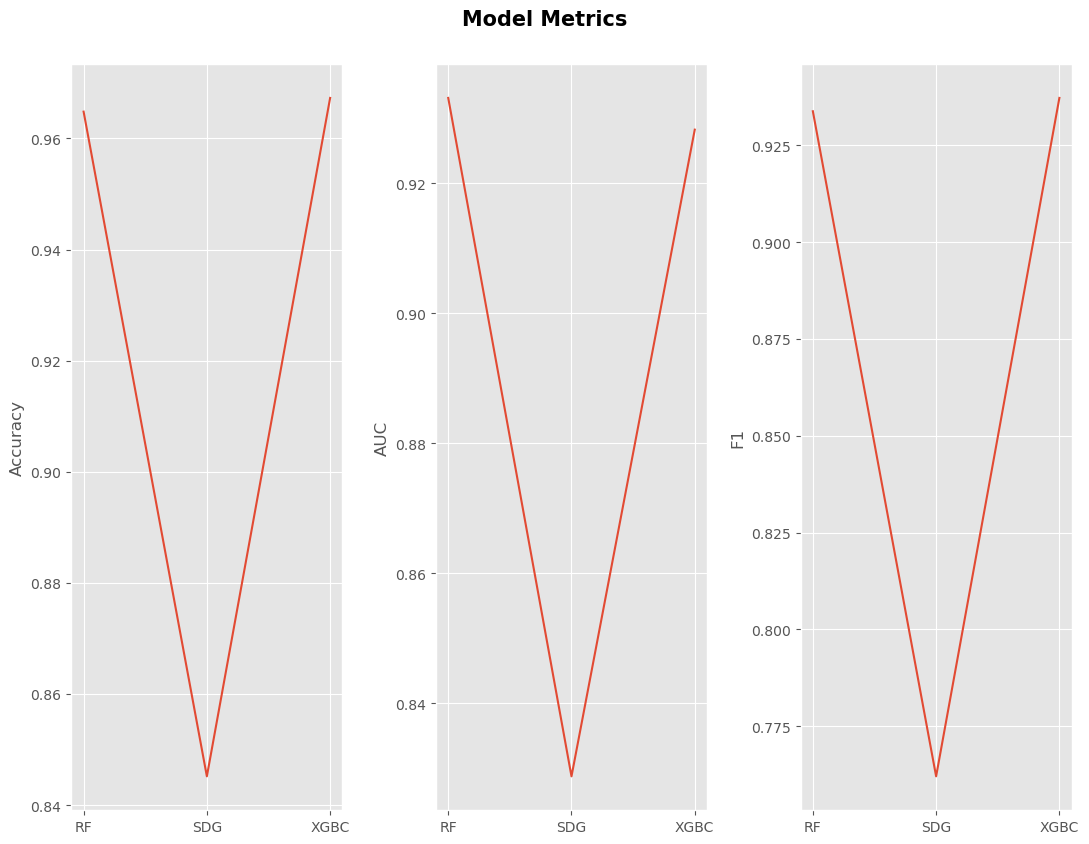

In [151]:
fig,axes= plt.subplots(1,3,figsize=(11,8))

for i,col in enumerate(metrics_models.columns):
    sns.lineplot(data=metrics_models[col],ax=axes[i] )

plt.tight_layout() 
plt.suptitle("Model Metrics", fontsize = 15, fontweight = "bold", y=1.05)
plt.savefig('model_metrics.png',bbox_inches='tight')
plt.show()

In [120]:
false_Negative = [conf_matrix_rf[1,0],
                 conf_matrix_sdg[1,0],conf_matrix_xgbc[1,0]]
false_Negative_S = pd.Series(false_Negative,name="FN",index=["RF","SDG","XGBC"])  

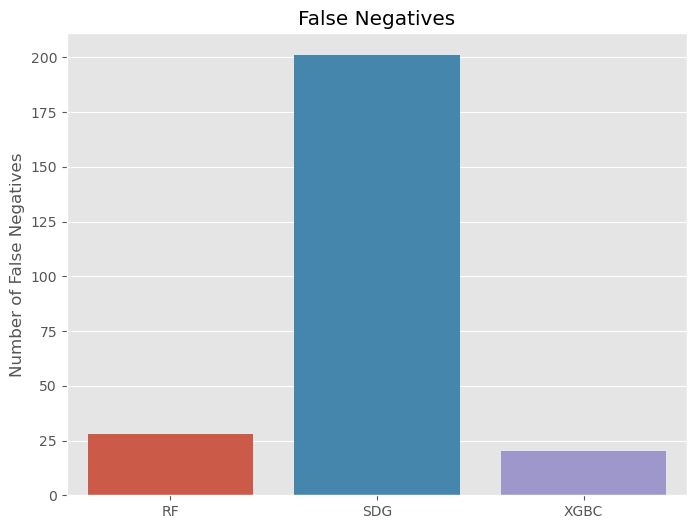

In [150]:
fig  = plt.figure(figsize=(8, 6))
sns.barplot(x=false_Negative_S.index,y=false_Negative_S.values)
plt.ylabel("Number of False Negatives")
plt.title("False Negatives")
plt.savefig('false_negatives.png',bbox_inches='tight')
plt.show()


The RF and XGB model have almost the same f1, with the XGB being slightly higher, but has a greater reduction of false negatives. XGB will be chosen because of its slight increase in f1 but undoubtedly the reduction in false negatives is something of great importance as it represents customers that the model classifies as satisfied with the bank's service but are really customers who are likely to cease using the bank's services.

# Test

In [122]:
X_Test = test.copy().drop(columns='CLIENTNUM')

In [123]:
test_cat_cols = X_Test.select_dtypes(object).columns
test_cat_cols

Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')

In [124]:
X_Test[test_cat_cols] = enc.transform(X_Test[test_cat_cols])

In [125]:
X_Test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2026 entries, 0 to 2025
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_Age              2026 non-null   int64  
 1   Gender                    2026 non-null   float64
 2   Dependent_count           2026 non-null   int64  
 3   Education_Level           2026 non-null   float64
 4   Marital_Status            2026 non-null   float64
 5   Income_Category           2026 non-null   float64
 6   Card_Category             2026 non-null   float64
 7   Months_on_book            2026 non-null   int64  
 8   Total_Relationship_Count  2026 non-null   int64  
 9   Months_Inactive_12_mon    2026 non-null   int64  
 10  Contacts_Count_12_mon     2026 non-null   int64  
 11  Credit_Limit              2026 non-null   float64
 12  Total_Revolving_Bal       2026 non-null   int64  
 13  Avg_Open_To_Buy           2026 non-null   float64
 14  Total_Am

In [126]:
X_Test[X_Test.columns] = scaler.transform(X_Test)

In [127]:
X_Test = X_Test.drop(columns=drop_cols)

In [144]:
final_model_prediction = gridXgbc.predict(X_Test) 

In [145]:
#create Series with predictions
final_prediction_series = pd.Series(data = final_model_prediction, name='target')
final_prediction_series

0       1
1       1
2       1
3       1
4       1
       ..
2021    1
2022    0
2023    1
2024    1
2025    1
Name: target, Length: 2026, dtype: int64

In [146]:
#convert series to json file
json_dict = {'target': final_prediction_series.to_dict()}
with open('predictions.json', 'w') as f:
    json.dump(json_dict, f)